# Aprendizaje máquina - Proyecto final


Integrantes:
- Ferrari, Maira
- Losada, Ricardo
- Pardo, Sebastian


## 1. Descripción General

El presente proyecto final tiene como objetivo principal la aplicación práctica e integral de los conceptos y técnicas de Aprendizaje Máquina abordados durante la asignatura. Se busca que el alumno demuestre su capacidad para abordar un problema de principio a fin, siguiendo el ciclo de vida estándar de un proyecto de ciencia de datos: desde la selección y comprensión de un conjunto de datos hasta la evaluación y comunicación de los resultados de un modelo predictivo.
Este trabajo representa la oportunidad de consolidar los conocimientos teóricos en un desafío práctico, desarrollando tanto habilidades técnicas como analíticas.

## 2. Objetivos de Aprendizaje

- Aplicar el flujo de trabajo completo de un proyecto de Machine Learning.
- Realizar un análisis exploratorio de datos (EDA) para extraer insights relevantes.
- Implementar técnicas de preprocesamiento y preparación de datos de manera justificada.
- Entrenar, optimizar y evaluar modelos de aprendizaje supervisado.
- Desarrollar la capacidad de comunicar de forma clara y profesional los métodos y resultados obtenidos.

# 3. Directrices y Requisitos del Proyecto
## 3.1. Formación de Grupos
El proyecto se podrá realizar de forma individual o en grupos de hasta un máximo de cuatro (4) integrantes.
## 3.2. Selección del Dataset
La elección del conjunto de datos es libre. Se recomienda encarecidamente seleccionar un problema de aprendizaje supervisado (clasificación o regresión), ya que se alinea mejor con los contenidos de la asignatura.
Sugerencia: Pueden explorar repositorios como Kaggle, UCI Machine Learning Repository, Google Dataset Search o datos abiertos de gobiernos para encontrar un dataset de su interés.
## 3.3. Estructura Obligatoria del Proyecto
El trabajo deberá estar estructurado en las siguientes secciones, que deben estar claramente diferenciadas y explicadas:
- Análisis Exploratorio de Datos (EDA):
   - Comprensión inicial del dataset,
   - Estadísticas descriptivas
   - Identificación de variables
   - Visualizaciones para entender distribuciones
   - Correlaciones y posibles problemas como valores nulos o atípicos.
- Preprocesamiento y Preparación de Datos:
    - Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a:
        - limpieza de datos,
        - imputación de valores faltantes,
        - codificación de variables categóricas,
        - escalado de características, etc.
- Modelización: Construcción y entrenamiento de los modelos de aprendizaje automático.
- Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.
## 3.4. Enfoque del Análisis
Se proponen dos posibles enfoques para la fase de modelización. El grupo deberá elegir uno:
- Opción A: Análisis Profundo. Centrarse en un único tipo de algoritmo (o una familia, ej. modelos basados en árboles) y realizar un análisis exhaustivo. Esto implica una búsqueda y optimización avanzada de hiperparámetros (ej. usando Grid Search, Randomized Search o Búsqueda Bayesiana) y un análisis detallado de su comportamiento.
- Opción B: Análisis Comparativo. Implementar y comparar el rendimiento de múltiples algoritmos de diferente naturaleza (ej. Regresión Logística, SVM, Árboles de Decisión, Redes Neuronales simples, etc.) para determinar cuál se adapta mejor al problema, justificando la elección final.
## 3.5. La Clave del Éxito: Explicación y Justificación
Este es el requisito más importante. No basta con presentar bloques de código y sus salidas. Cada paso del proyecto debe ir acompañado de una explicación detallada en texto. Deben justificar sus decisiones: ¿Por qué eligieron esa técnica de imputación? ¿Qué significa la correlación encontrada? ¿Qué métrica de evaluación es más relevante para este problema y por qué? ¿Qué conclusiones se extraen de los resultados?
Un entregable que contenga únicamente código no será considerado suficiente para superar la asignatura.

# 4. Formato y Entregable
El proyecto se puede entregar en uno de los siguientes dos formatos:
- Cuaderno Computacional: Un único fichero (.ipynb) de Jupyter Notebook o Google Colab, bien estructurado, con celdas de texto (Markdown) para las explicaciones y celdas de código para la implementación. Debe ser ejecutable y mostrar los resultados finales.
- Repositorio de GitHub: Un repositorio público que contenga el código, los datos (o un enlace a ellos) y un fichero README.md detallado que sirva como el informe principal del proyecto, explicando cada sección de manera clara y profesional.

En ambos casos, se valorará positivamente la claridad, la limpieza del código, la calidad de las visualizaciones y el profesionalismo general del entregable.
# 5. Hitos y Fechas de Entrega
- Hito 1 - Formación de Grupos: Se deberá notificar al profesor la composición de los grupos de trabajo por correo electrónico antes del inicio de la sesión número 6.
- Seguimiento: Se valorará positivamente que los grupos compartan avances parciales o dudas específicas durante las sesiones para recibir feedback y asegurar que el proyecto progresa adecuadamente.
- Entrega Final: El proyecto deberá ser enviado por correo electrónico al profesor antes de las 23:59h del día siguiente a la sesión número 8. El email debe incluir el enlace al repositorio de GitHub o el fichero del cuaderno adjunto.



# Resolucion - Opcion elegida - B) Analisis Comparativo

# 🏡 Dataset Elegido - Airbnb Listings Data Dictionary

> Diccionario de datos del conjunto de listados de Airbnb, con tipos de datos, campos calculados y descripciones.  
> Compatible con visualización en GitHub (scroll horizontal automático en tablas grandes).

---

<div style="overflow-x: auto;">

| **Field** | **Type** | **Calculated** | **Description** |
|------------|-----------|----------------|-----------------|
| id | integer |  | Airbnb's unique identifier for the listing |
| listing_url | text | ✅ |  |
| scrape_id | bigint | ✅ | Inside Airbnb "Scrape" this was part of |
| last_scraped | datetime | ✅ | UTC. The date and time this listing was "scraped". |
| source | text |  | One of `"neighbourhood search"` or `"previous scrape"`. Describes how the listing was discovered. |
| name | text |  | Name of the listing |
| description | text |  | Detailed description of the listing |
| neighborhood_overview | text |  | Host's description of the neighbourhood |
| picture_url | text |  | URL to Airbnb-hosted regular-sized image |
| host_id | integer |  | Airbnb's unique identifier for the host/user |
| host_url | text | ✅ | Airbnb page for the host |
| host_name | text |  | Name of the host (usually first name). |
| host_since | date |  | Host account creation date |
| host_location | text |  | Host's self-reported location |
| host_about | text |  | Description about the host |
| host_response_time | text |  |  |
| host_response_rate | text |  |  |
| host_acceptance_rate | text |  | Rate at which host accepts booking requests |
| host_is_superhost | boolean *(t=true; f=false)* |  |  |
| host_thumbnail_url | text |  |  |
| host_picture_url | text |  |  |
| host_neighbourhood | text |  |  |
| host_listings_count | text |  | Number of listings (Airbnb internal) |
| host_total_listings_count | text |  | Total listings (Airbnb internal) |
| host_verifications | text |  |  |
| host_has_profile_pic | boolean *(t=true; f=false)* |  |  |
| host_identity_verified | boolean *(t=true; f=false)* |  |  |
| neighbourhood | text |  |  |
| neighbourhood_cleansed | text | ✅ | Geocoded neighbourhood (from shapefiles) |
| neighbourhood_group_cleansed | text | ✅ | Geocoded neighbourhood group (from shapefiles) |
| latitude | numeric |  | WGS84 latitude |
| longitude | numeric |  | WGS84 longitude |
| property_type | text |  | Self-selected property type |
| room_type | text |  | One of:<br>• **Entire home/apt** — Whole space<br>• **Private room** — Own room, shared areas<br>• **Shared room** — Shared sleeping space |
| accommodates | integer |  | Max guest capacity |
| bathrooms | numeric |  | Number of bathrooms |
| bathrooms_text | string |  | Text description of bathrooms (legacy field) |
| bedrooms | integer |  | Number of bedrooms |
| beds | integer |  | Number of beds |
| amenities | json |  | JSON array of amenities |
| price | currency |  | Daily price (ignore `$` artifact) |
| minimum_nights | integer |  | Minimum nights allowed |
| maximum_nights | integer |  | Maximum nights allowed |
| minimum_minimum_nights | integer | ✅ | Smallest min nights (calendar, 365 days ahead) |
| maximum_minimum_nights | integer | ✅ | Largest min nights (calendar, 365 days ahead) |
| minimum_maximum_nights | integer | ✅ | Smallest max nights (calendar, 365 days ahead) |
| maximum_maximum_nights | integer | ✅ | Largest max nights (calendar, 365 days ahead) |
| minimum_nights_avg_ntm | numeric | ✅ | Avg min nights (calendar, 365 days ahead) |
| maximum_nights_avg_ntm | numeric | ✅ | Avg max nights (calendar, 365 days ahead) |
| calendar_updated | date |  |  |
| has_availability | boolean |  | *(t=true; f=false)* |
| availability_30 | integer | ✅ | Available nights (next 30 days) |
| availability_60 | integer | ✅ | Available nights (next 60 days) |
| availability_90 | integer | ✅ | Available nights (next 90 days) |
| availability_365 | integer | ✅ | Available nights (next 365 days) |
| calendar_last_scraped | date |  |  |
| number_of_reviews | integer |  | Total number of reviews |
| number_of_reviews_ltm | integer | ✅ | Reviews in last 12 months |
| number_of_reviews_l30d | integer | ✅ | Reviews in last 30 days |
| first_review | date | ✅ | Date of first review |
| last_review | date | ✅ | Date of most recent review |
| review_scores_rating | numeric |  |  |
| review_scores_accuracy | numeric |  |  |
| review_scores_cleanliness | numeric |  |  |
| review_scores_checkin | numeric |  |  |
| review_scores_communication | numeric |  |  |
| review_scores_location | numeric |  |  |
| review_scores_value | numeric |  |  |
| license | text |  | Licence/permit/registration number |
| instant_bookable | boolean |  | *(t=true; f=false)* — Guests can book instantly |
| calculated_host_listings_count | integer | ✅ | Number of listings host has in this scrape (city/region) |
| calculated_host_listings_count_entire_homes | integer | ✅ | Entire homes owned by host |
| calculated_host_listings_count_private_rooms | integer | ✅ | Private rooms owned by host |
| calculated_host_listings_count_shared_rooms | integer | ✅ | Shared rooms owned by host |
| reviews_per_month | numeric | ✅ | Average reviews per month over listing lifetime.<br><br>**Pseudocode/SQL:**<br>`IF scrape_date - first_review <= 30 THEN number_of_reviews`<br>`ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))` |

</div>

---

✅ = Calculated field  
📘 *Boolean values*: `t=true`, `f=false`  
🌐 *Coordinates*: WGS84 projection  
💡 *Source*: [Inside Airbnb](https://insideairbnb.com/)


## 1. Carga y saneamiento inicial

Antes de empezar con el análisis exploratorio, cargamos el dataset y realizamos una limpieza básica para asegurarnos de que los datos tengan un formato utilizable.

Primero, configuramos el entorno de trabajo (librerías, tamaño de figuras y formato de impresión) para facilitar la lectura del notebook.

Luego hacemos algunas transformaciones iniciales:

- Carga del CSV: especificamos distintos valores que representan “nulo” para unificarlos.
- Limpieza de price: esta columna venía como texto con símbolos (ej. “$1,200”), así que eliminamos caracteres no numéricos y la convertimos a float.
- Conversión de fechas: transformamos columnas como host_since o last_review a tipo datetime, ya que luego derivaremos features temporales.
- host_id a string: lo convertimos a texto para poder agrupar o discretizar más adelante (por defecto estaba como número).

Finalmente, confirmamos que el número de filas/columnas se mantiene tras estas transformaciones.

Estas correcciones nos dejan el dataset en un estado “usable” para continuar con el EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import missingno as msno

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = Path('listings_big.csv')

def get_missing(df_full: pd.DataFrame):
    missing_abs = df_full.isna().sum().sort_values(ascending=False)
    missing_pct = (missing_abs / len(df_full)).round(4)
    missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
    return missing_table[missing_table["missing"]>0]


In [2]:
df_raw = pd.read_csv(
    DATA_PATH,
    na_values=("N/A", "NA", "na", "n/a", "", "-", ".","nan"),
    keep_default_na=True
)

df = df_raw.copy()

# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())

df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

#Convertimos a string el host_id para discretizarlo luego

df['host_id'] = df['host_id'].astype('string')

print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.1 Información general del dataset

Antes de profundizar en el análisis, necesitamos entender la estructura del dataset: qué columnas tiene, qué tipos de datos maneja y cuántos valores faltantes hay.

Para eso, generamos una tabla personalizada que incluye:

- Índice y nombre de cada columna
- Cantidad de valores no nulos
- Tipo de dato (dtype)

Esta visión general nos permite identificar:

- Columnas numéricas vs categóricas vs fechas
- Variables que podrían estar mal tipadas (por ejemplo, números guardados como texto)
- Posibles columnas con muchos nulos que requerirán tratamiento

Además, creamos un resumen de la cantidad de columnas por tipo de dato, lo cual nos ayuda a planificar el preprocesamiento. Por ejemplo, si hay muchas columnas categóricas, ya sabemos que más adelante necesitaremos técnicas de codificación (one-hot encoding, ordinal, etc.).

Por otro lado generamos un resumen estadístico de las variables numéricas adaptado a nuestro caso:
- Excluimos columnas que no tienen sentido estadístico (IDs, claves, etc.)
- Formateamos algunas columnas como price o estimated_revenue_l365d para que sean más fáciles de leer
- Esta exploración inicial nos da un panorama general del dataset y nos prepara para detectar problemas (nulos, outliers, tipos incorrectos) y para tomar mejores decisiones en las siguientes etapas del EDA.

Además de revisar las variables numéricas, es importante entender cómo se comportan las variables categóricas del dataset.
Para eso, primero seleccionamos todas las columnas de tipo object o string y generamos un resumen estadístico (describe()), que nos muestra:

- Cuántos valores no nulos tiene cada columna (count)
- Cuántos valores distintos hay (unique)
- Cuál es la categoría más frecuente (top)
- Con qué frecuencia aparece (freq)

Luego ordenamos las variables por frecuencia máxima para identificar:
- Columnas con una categoría dominante (poca variabilidad)
- Columnas con demasiadas categorías distintas (alto cardinalidad)
- Variables que pueden necesitar otro tipo de codificación (por ejemplo, target encoding en lugar de one-hot)
- Posibles columnas irrelevantes o con información poco útil

Este análisis nos ayuda a decidir cómo vamos a tratar las variables categóricas en el preprocesamiento (encoding, reducción de cardinalidad, agrupamientos, etc.).

In [3]:
def info_as_table(_df: pd.DataFrame):
    rows = []
    for idx, c in enumerate(df.columns):
        rows.append({
            "#": idx,
            "Column": c,
            "Non-Null Count": int(_df[c].notna().sum()),
            "Dtype": str(_df[c].dtype),
        })
    tbl = pd.DataFrame(rows, columns=["#","Column","Non-Null Count","Dtype"])
    return (tbl.style
                .hide(axis="index")
                .format({"#":"{:d}", "Non-Null Count":"{:d}"}))

info_as_table(df)


#,Column,Non-Null Count,Dtype
0,id,35172,int64
1,listing_url,35172,object
2,scrape_id,35172,int64
3,last_scraped,35172,datetime64[ns]
4,source,35172,object
5,name,35172,object
6,description,34294,object
7,neighborhood_overview,16585,object
8,picture_url,35171,object
9,host_id,35172,string


In [4]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,23
float64,21
datetime64[ns],4
string[python],1


In [5]:
# Estadísticas descriptivas de variables numéricas

def format_numeric_summary(df, exclude_patterns=("id",), currency_cols=None, decimals=4):
    # excluimos columnas que no tienen sentido estadístico

    columns_to_exclude = [c for c in df.columns if any(pat in c.lower() for pat in exclude_patterns)]
    summary_num = (
        df.drop(columns=columns_to_exclude)
          .select_dtypes(include="number")
          .describe()
          .T
          .round(decimals)
    )

    summary_fmt = summary_num.copy().astype(object)

    if currency_cols:
        for col in currency_cols:
            if col in summary_fmt.index:
                summary_fmt.loc[col] = summary_num.loc[col].apply(lambda x: f"${x:,.{decimals}f}")

    return summary_num, summary_fmt

columns_to_exclude = ["id", "scrape_id", "host_id", "calendar_updated","neighbourhood_group_cleansed"]
currency_cols = ["price", "estimated_revenue_l365d"]

numeric_summary, numeric_summary_fmt = format_numeric_summary(
    df,
    exclude_patterns=columns_to_exclude,
    currency_cols=currency_cols,
    decimals=2
)

numeric_summary_fmt


,count,mean,std,min,25%,50%,75%,max
host_listings_count,35166.0000,19.5400,41.2900,1.0000,1.0000,3.0000,16.0000,670.0000
host_total_listings_count,35166.0000,29.4300,79.5800,1.0000,1.0000,4.0000,20.0000,2542.0000
latitude,35172.0000,-34.5900,0.0200,-34.6900,-34.6000,-34.5900,-34.5800,-34.5300
longitude,35172.0000,-58.4200,0.0300,-58.5300,-58.4400,-58.4200,-58.3900,-58.3600
accommodates,35172.0000,2.9400,1.5500,1.0000,2.0000,2.0000,4.0000,16.0000
bathrooms,31602.0000,1.2400,0.6600,0.0000,1.0000,1.0000,1.0000,22.0000
bedrooms,34445.0000,1.1900,0.9400,0.0000,1.0000,1.0000,1.0000,35.0000
beds,31604.0000,1.9100,1.6000,0.0000,1.0000,1.0000,2.0000,36.0000
price,"$31,598.00","$95,487.76","$1,402,656.42",$260.00,"$29,711.00","$39,908.00","$57,762.00","$105,021,704.00"
minimum_nights,35172.0000,6.1600,26.0700,1.0000,1.0000,2.0000,4.0000,1000.0000


In [6]:
# Estadísticas básicas de variables categóricas/cadenas

categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary_sorted = categorical_summary.sort_values("freq", ascending=False)

categorical_summary_sorted.head(25)


,count,unique,top,freq
host_identity_verified,35166,2,t,34159
has_availability,34005,2,t,33940
host_has_profile_pic,35166,2,t,33717
room_type,35172,4,Entire home/apt,32083
source,35172,2,city scrape,31613
host_verifications,35166,7,"['email', 'phone']",28522
calendar_last_scraped,35172,4,2025-01-30,26254
property_type,35172,66,Entire rental unit,25470
bathrooms_text,35148,48,1 bath,25236
instant_bookable,35172,2,f,24046


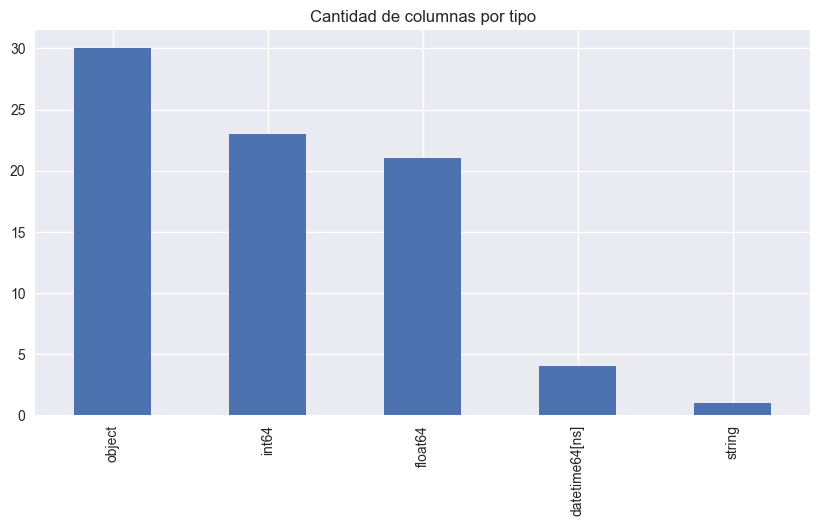

In [7]:
type_summary.plot(kind='bar', legend=False, figsize=(10,5), title='Cantidad de columnas por tipo')
plt.show()



### 1.2 Exploración de duplicados y consistencia

Antes de avanzar con el análisis, verificamos si existen problemas de duplicados o inconsistencias en las claves identificadoras del dataset.
En este caso, la columna id representa el identificador único de cada anuncio/listing.

Por lo tanto:

- Si existen valores duplicados en id, podríamos estar analizando el mismo listing más de una vez.

- Si hay valores nulos en id, habría filas que no se pueden identificar correctamente, lo cual podría causar problemas al entrenar el modelo.

Revisamos ambas condiciones y encontramos:
- 0 duplicados
- 0 ids faltantes

Esto nos da tranquilidad de que cada fila corresponde a un listing único y que no es necesario eliminar o corregir registros en esta etapa.

In [8]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes

En primer lugar, calculamos cuántos valores faltantes tiene cada columna del dataset. Esto nos permite identificar qué variables requieren algún tipo de tratamiento (imputación, eliminación o transformación).

Ordenamos las columnas por porcentaje de nulos y mostramos las más afectadas. Observamos que algunas variables tienen más del 50% de datos faltantes, e incluso hay columnas con el 100% de valores nulos. Estas columnas probablemente no aporten información útil al modelo y podrían eliminarse más adelante.

Visualizamos este top de columnas con un gráfico de barras para entender rápidamente la magnitud del problema.


In [9]:
missing_table = get_missing(df)
missing_table.head(30)

,missing,percent
neighbourhood_group_cleansed,35172,100.0000
calendar_updated,35172,100.0000
license,34783,98.8900
neighborhood_overview,18587,52.8500
neighbourhood,18584,52.8400
host_about,16360,46.5100
host_neighbourhood,13451,38.2400
host_location,7553,21.4700
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800


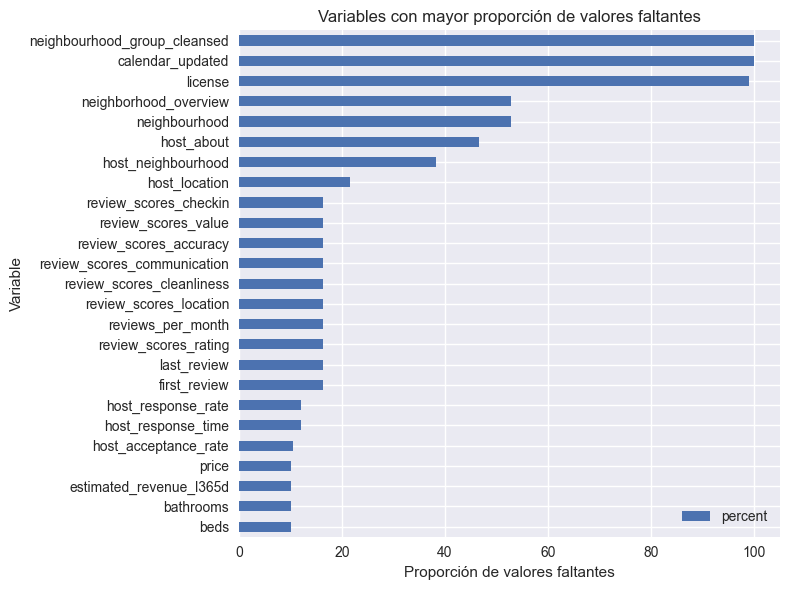

In [10]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing =  missing_table.head(25)

ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')

plt.tight_layout()
plt.show()


Sin embargo, mirar columnas individuales no siempre es suficiente.
Muchas variables pertenecen a un mismo “tema” (por ejemplo, información del host, datos del anuncio, reseñas, ubicación, precio, etc.).
Por eso, decidimos agrupar las columnas por categorías semánticas para analizar los nulos a nivel de grupo.

Grupos Detectados:

- Host info: columnas relacionadas al anfitrión
- Reviews: variables asociadas a reseñas
- Price: columnas de precio o ingresos estimados
- Location: información de barrio / descripción geográfica
- Listing: características del anuncio (tipo de propiedad, habitaciones, amenities, etc.)
- Otros: variables que no encajan en los grupos anteriores

Esta agrupación nos permite entender mejor en qué parte del dataset se concentran los problemas de calidad de datos.


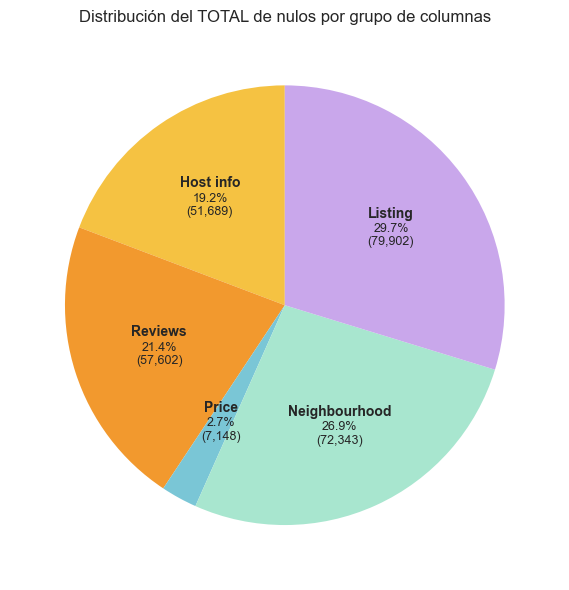

 Host info: 51,689 nulos (19.2378%)
   Reviews: 57,602 nulos (21.4386%)
     Price: 7,148 nulos (2.6604%)
Neighbourhood: 72,343 nulos (26.9249%)
   Listing: 79,902 nulos (29.7383%)
------------------------------
     TOTAL: 268,684 nulos (100.0000%)


In [11]:
import matplotlib.pyplot as plt

keywords_host = ['host', 'night']
host_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_host)
]

keywords_listing = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'picture_url', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'calendar_updated', 'calendar_last_scraped', 'license', 'instant_bookable','availability', 'night','tasa_ocupacion','estimated_occupancy_l365d']
listing_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_listing)
]

review_cols = [c for c in df.columns if 'review' in c.lower()]

keywords_barrio = ['neighbourhood', 'neighborhood_overview']

location_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_barrio)   # contiene alguna keyword
    and c not in host_cols                              # NO está en host
]

# Price: si existe
price_cols = ['price','estimated_revenue_l365d'] if 'price' in df.columns else []

# Otros: todo lo que no entra en los grupos anteriores
grouped = set(host_cols + review_cols + price_cols  + location_cols + listing_cols)
other_cols = [c for c in df.columns if c not in grouped]

def nulls_in(cols):
    return df[cols].isna().sum().sum() if cols else 0

null_host   = nulls_in(host_cols)
null_review = nulls_in(review_cols)
null_price  = nulls_in(price_cols)
null_other  = nulls_in(other_cols)
null_location = nulls_in(location_cols)
null_listing = nulls_in(listing_cols)

total_nulls = null_host + null_review + null_price + null_other  + null_location + null_listing
if total_nulls == 0:
    print("No hay nulos en el dataset.")
else:
    labels = ['Host info', 'Reviews', 'Price', 'Neighbourhood', 'Listing']
    sizes  = [null_host, null_review, null_price, null_location, null_listing]

    colors = ['#F5C242', '#F2992E', '#7AC6D6', '#A8E6CF', '#C9A7EB', '#F8BBD0']

    plt.figure(figsize=(6,6))
    wedges, _ = plt.pie(
        sizes,
        labels=None,
        colors=colors,
        startangle=90
    )

    for wedge, lab, val in zip(wedges, labels, sizes):
        ang = (wedge.theta2 + wedge.theta1) / 2
        r = 0.60
        x = r * np.cos(np.deg2rad(ang))
        y = r * np.sin(np.deg2rad(ang))
        pct = val / total_nulls * 100

        # Línea superior: label
        plt.text(x, y + 0.06, lab, ha='center', va='center', fontsize=10, weight='bold')

        # Línea inferior: % y cuenta, un poco más abajo para separación
        plt.text(x, y - 0.04, f'{pct:.1f}%\n({val:,})', ha='center', va='center', fontsize=9)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Distribución del TOTAL de nulos por grupo de columnas')
    plt.tight_layout()
    plt.show()


total_pct = 0
for lab, val in zip(labels, sizes):
    pct = val / total_nulls * 100
    total_pct += pct
    print(f'{lab:>10}: {val:,} nulos ({pct:.4f}%)')

print('-' * 30)
print(f'{"TOTAL":>10}: {total_nulls:,} nulos ({total_pct:.4f}%)')


Calculamos el total de valores faltantes en cada grupo y construimos un gráfico de torta para visualizar la proporción de nulos por categoría.

Este análisis revela que:
- Gran parte de los valores faltantes provienen de información del host, del listing y descripciones de barrio.
- Las reseñas también contienen una cantidad considerable de nulos (porque muchos anuncios no tienen reviews).
- El precio tiene pocos nulos, lo cual es positivo ya que es una variable importante para el modelado.

Gracias a este análisis, podemos decidir qué columnas eliminar (por ejemplo, las de +90% nulos) y qué variables imputar o transformar en la siguiente etapa de preprocesamiento.

En resumen, no todos los nulos son iguales. Algunos se concentran en grupos poco relevantes o descriptivos (barrio, host), mientras que otros afectan variables potencialmente útiles (precios o reviews). En la siguiente sección tomaremos decisiones sobre qué columnas eliminar y cómo imputar los valores faltantes de manera justificada.

Además de ver cuántos valores faltan, es útil analizar cómo se relacionan los nulos entre columnas.
Si dos columnas suelen estar vacías al mismo tiempo, significa que el “patrón de ausencia” no es aleatorio.

Por eso usamos un heatmap de correlación de nulos (missingno), que mide la probabilidad de que dos variables estén ambas vacías.
Esto nos ayuda a identificar grupos de columnas que comparten la misma fuente de información o que dependen entre sí.

Por ejemplo podemos ver que:

- Varias columnas de host tienen correlaciones cercanas a 1 → si falta una, probablemente falten las otras.
- Las columnas de reviews también muestran patrones similares (anuncios sin reseñas tienen múltiples campos vacíos al mismo tiempo).

Este análisis nos permite tomar mejores decisiones de imputación o eliminación de columnas:

- Si varias columnas fallan juntas, quizás con eliminar una sola variable redundante sea suficiente.
- También ayuda a evitar imputar de forma incoherente variables que dependen entre sí.

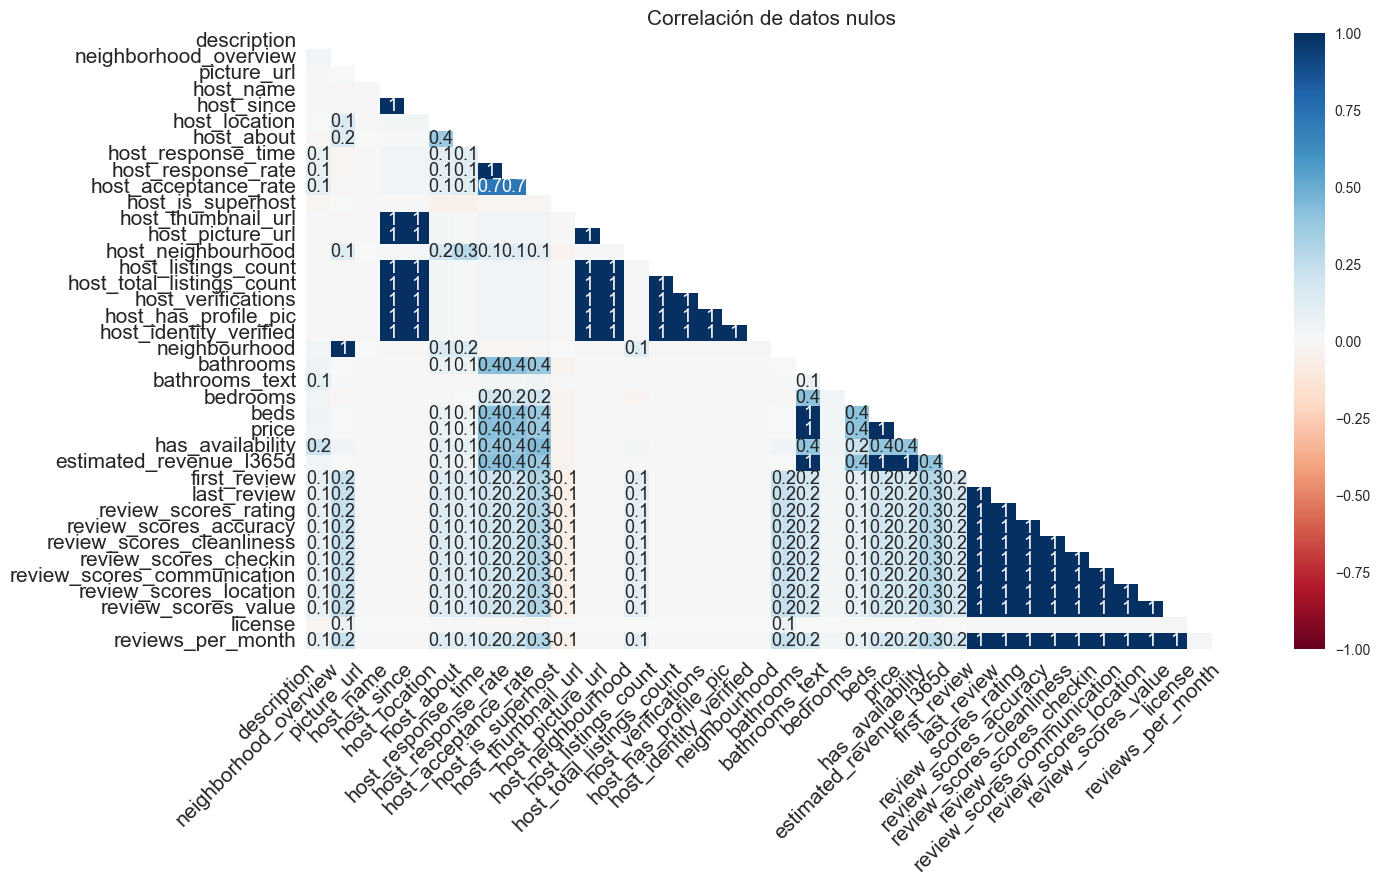

In [12]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

Para visualizar estos patrones de manera más clara, generamos un dendrograma de valores faltantes, que agrupa jerárquicamente las columnas según la similitud de su patrón de nulos.

Interpretación:

Columnas que aparecen juntas en una rama comparten un mismo comportamiento de ausencia de datos.

Las ramas largas y aisladas indican columnas con patrones únicos de nulos.

Esto refuerza la idea de que:
- Muchas columnas del host comparten el mismo patrón de faltantes.
- Lo mismo ocurre con variables de reviews.
- Algunas columnas tienen patrones completamente distintos y deben tratarse individualmente.

En resumen, no solo identificamos qué columnas tienen nulos, sino también cómo se relacionan entre sí, lo cual nos permite diseñar una estrategia de preprocesamiento más informada:

- qué columnas eliminar
- cuáles imputar
- y qué grupos de variables deben tratarse en conjunto.


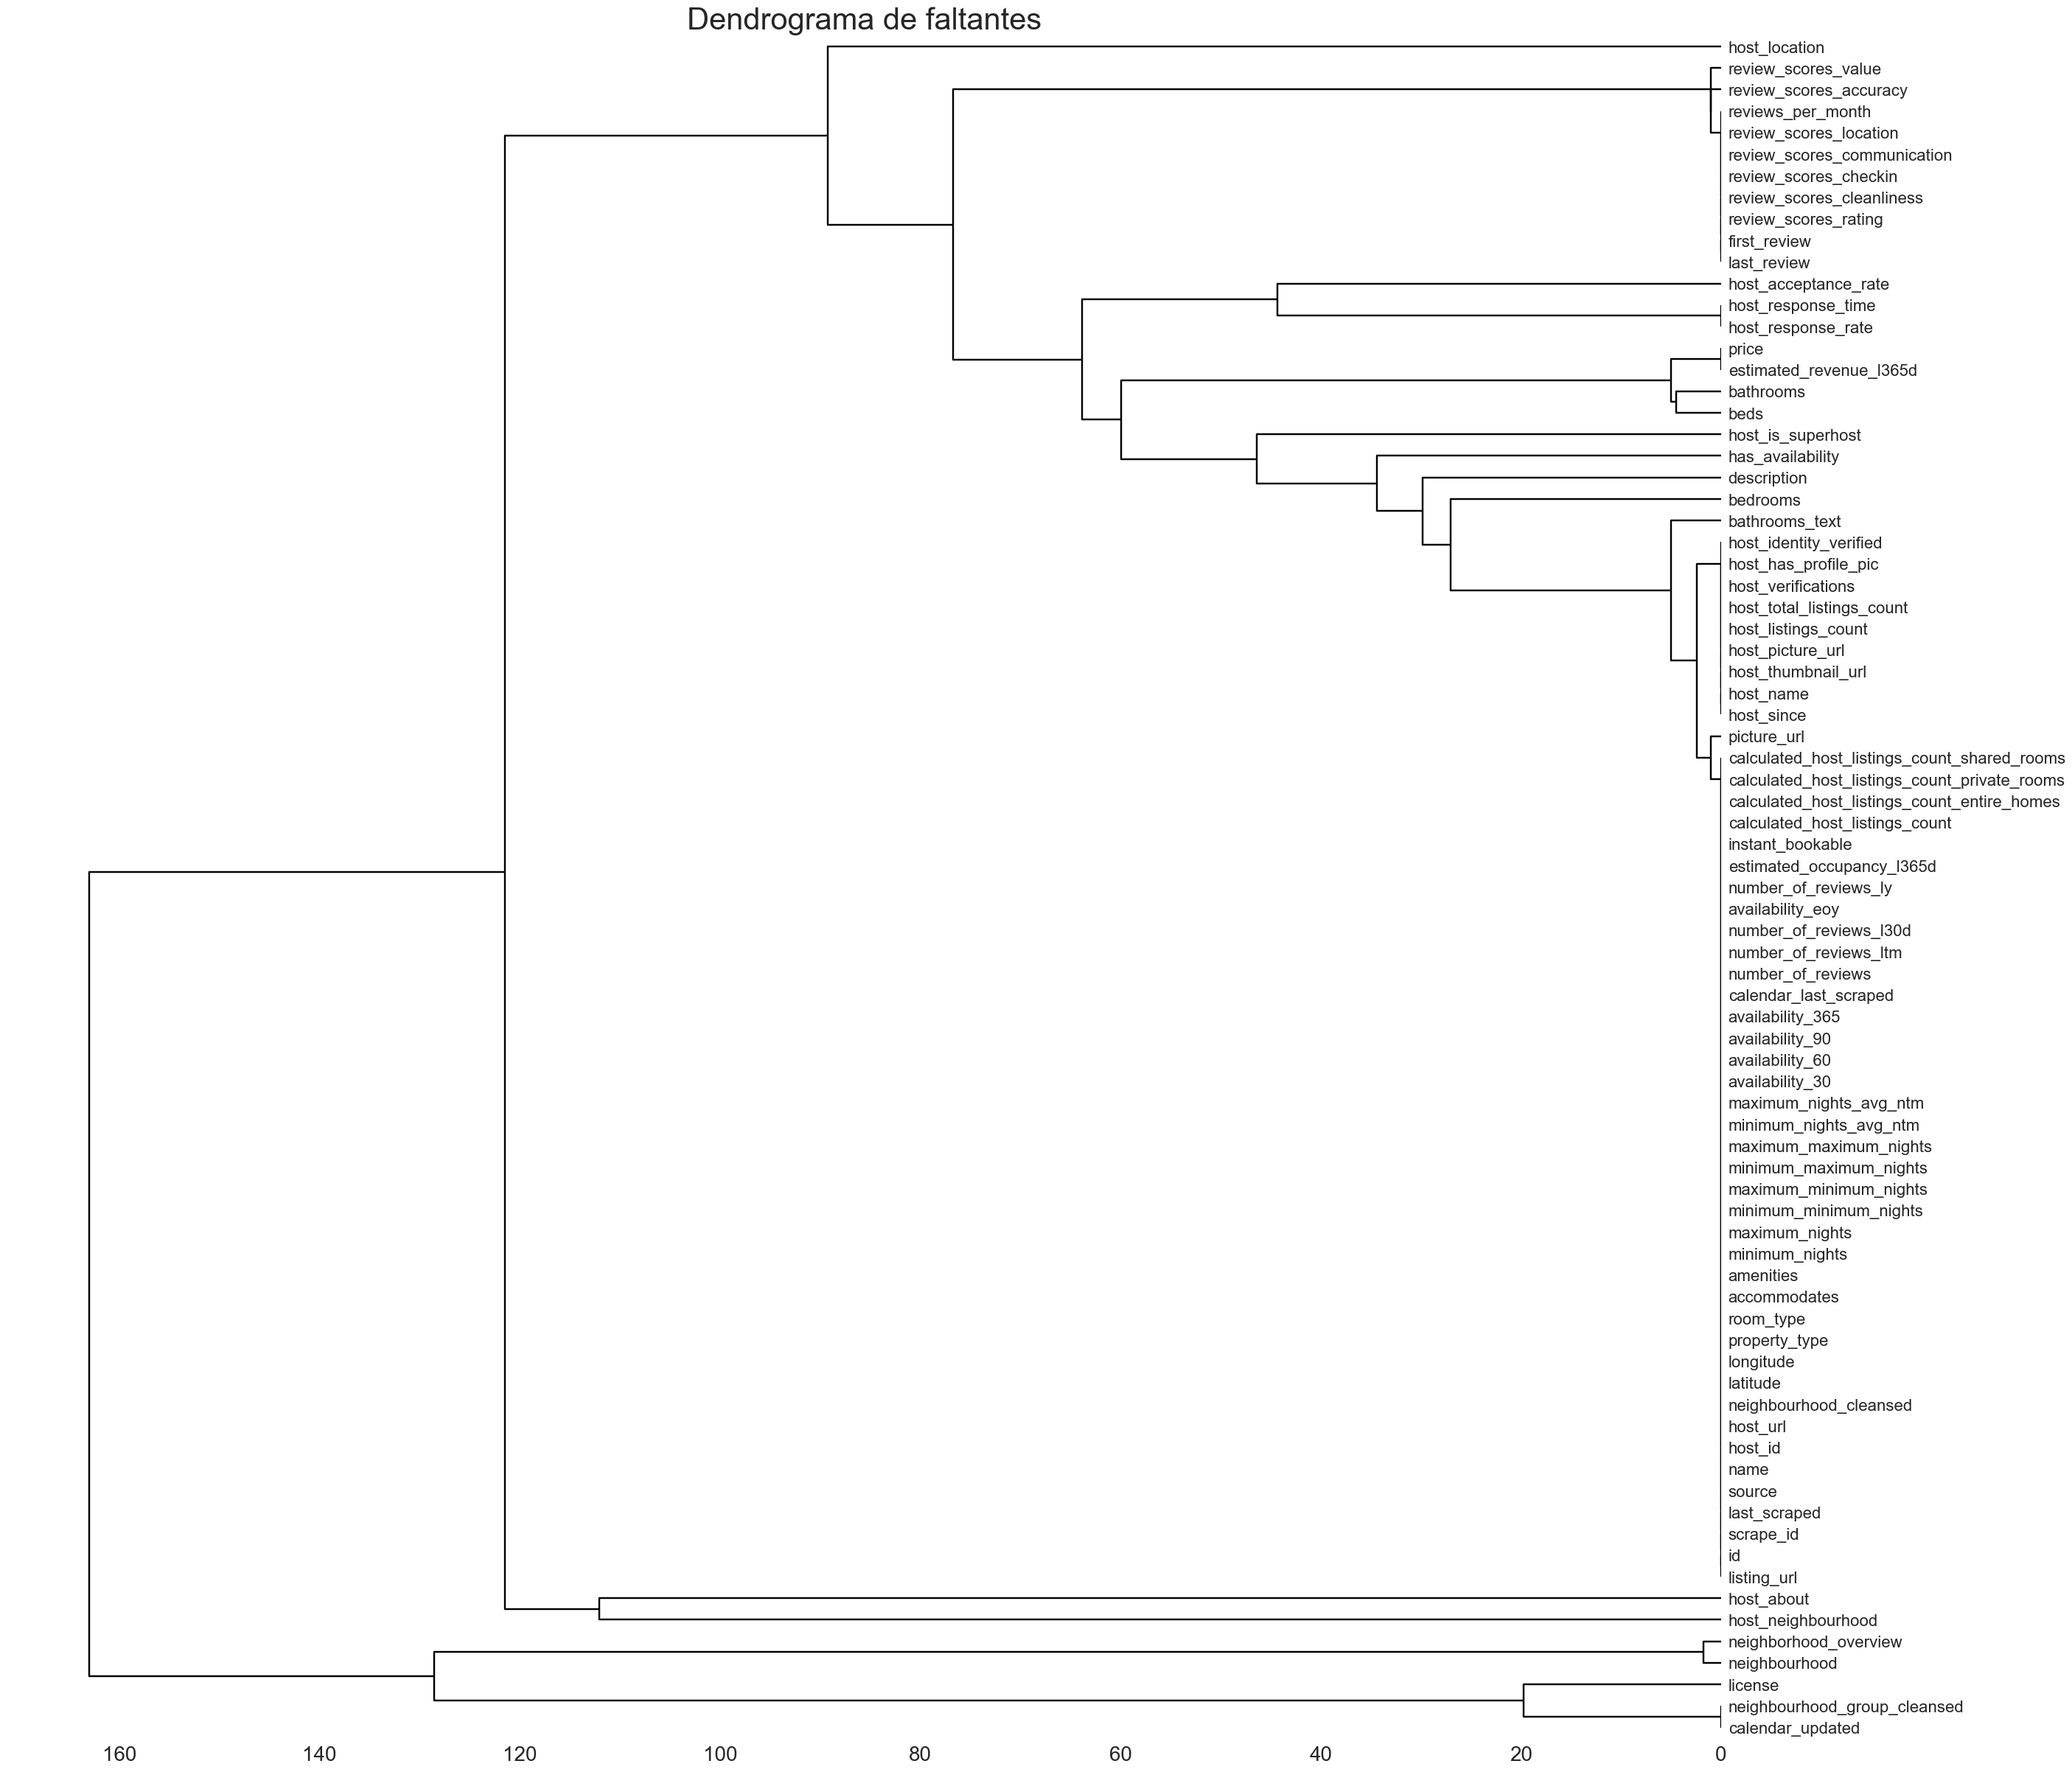

In [13]:
msno.dendrogram(df, figsize=(30,30))
plt.title('Dendrograma de faltantes', fontsize=30)
plt.show()

## 2.1 Patrón de valores faltantes: MCAR / MAR / MNAR

Además de contar cuántos nulos hay, nos interesa entender por qué faltan. No es lo mismo que falte “al azar” que falte porque depende de otra variable.

- MCAR (Missing Completely At Random): los faltantes no se explican por nada observable.
- MAR (Missing At Random): los faltantes se asocian a alguna variable observada (ej., barrio, tipo de propiedad).
- MNAR (Missing Not At Random): los faltantes dependen de la propia variable o de factores no observados (típico cuando el “driver” también está muy incompleto).

¿Qué hicimos?

- Construimos una máscara de nulos que también captura strings vacíos/”nan”/“null”.
- Armamos un set de features numéricas (parseando strings con símbolos a número) y categóricas (limitando cardinalidad).
- Para cada columna con nulos, medimos asociación del patrón de ausencia contra el resto:
- Numéricas: diferencia de medias estandarizada entre filas con y sin dato (tamaño de efecto).
- Categóricas: máxima diferencia de frecuencias (qué categoría “salta” cuando falta el dato).

Resultado:
- Si no encontramos asociaciones relevantes → MCAR.
- Si hay asociación con otra variable que está razonablemente completa → MAR.
- Si la asociación existe pero el “driver” también está muy incompleto (o sospechamos dependencia no observada) → MNAR.

Esto nos da una tabla de clasificación por columna (MCAR/MAR/MNAR) con el “driver” más influyente y el tamaño de efecto. Con eso, en la siguiente etapa podemos imputar de forma informada.

In [14]:
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def missing_mask(series: pd.Series) -> pd.Series:
    """True cuando el valor debe considerarse nulo (NaN real o string vacío)."""
    base_mask = series.isna()
    string_mask = series.astype(str).str.strip().isin(NULL_TOKENS)
    return base_mask | string_mask

# Construcción de features de referencia 
def build_numeric_features(df: pd.DataFrame, min_valid_frac: float = 0.50) -> dict:
    numeric_features = {}
    for col in df.columns:
        series = df[col]
        cleaned = (
            series.astype(str)
                  .str.replace(r"[^\d\.\-]", "", regex=True)
                  .replace("", pd.NA)
        )
        numeric = pd.to_numeric(cleaned, errors="coerce")
        if numeric.notna().mean() >= min_valid_frac:
            numeric_features[col] = numeric
    return numeric_features

def build_categorical_features(df: pd.DataFrame, max_cardinality: int = 30) -> dict:
    categorical_features = {}
    for col in df.columns:
        series = df[col]
        if series.dtype == "O" or series.dtype == "bool":
            if 1 <= series.dropna().nunique() <= max_cardinality:
                categorical_features[col] = series.fillna("Missing")
    return categorical_features

numeric_features = build_numeric_features(df)
categorical_features = build_categorical_features(df)

# Medidas de asociación entre patrón de nulos y otras columnas 
def numeric_effect(nan_mask: pd.Series, series: pd.Series):
    available = series.notna()
    if available.sum() == 0:
        return None
    miss = nan_mask & available
    present = (~nan_mask) & available
    if miss.sum() == 0 or present.sum() == 0:
        return None
    diff = series[miss].mean() - series[present].mean()
    std = series[available].std()
    if pd.isna(std) or std == 0:
        return None
    return abs(diff) / std  # diferencia estandarizada

def categorical_effect(nan_mask: pd.Series, series: pd.Series):
    miss = nan_mask
    present = ~nan_mask
    if miss.sum() == 0 or present.sum() == 0:
        return None
    freq_miss = series[miss].value_counts(normalize=True)
    freq_present = series[present].value_counts(normalize=True)
    combined = pd.concat([freq_miss, freq_present], axis=1, keys=["missing", "present"]).fillna(0)
    combined["diff"] = (combined["missing"] - combined["present"]).abs()
    return combined["diff"].max()

# Clasificación MCAR / MAR / MNAR
missing_counts = {col: missing_mask(df[col]).sum() for col in df.columns}
missing_pct = {col: round(count / len(df) * 100, 2) for col, count in missing_counts.items()}
missing_summary = (
    pd.DataFrame({"missing": missing_counts, "missing_pct": missing_pct})
      .query("missing > 0")
      .sort_values("missing_pct", ascending=False)
)

results = []
row_count = len(df)

for col in missing_summary.index:
    mask = missing_mask(df[col])

    if missing_summary.loc[col, "missing"] == row_count:
        results.append({
            "column": col,
            "missing": missing_summary.loc[col, "missing"],
            "missing_pct": missing_summary.loc[col, "missing_pct"],
            "category": "Estructural",
            "driver": None,
            "effect_size": None,
            "notes": "100% ausente en el scrape; indicio de campo no disponible en la fuente."
        })
        continue

    best_effect = 0
    best_driver = None
    best_type = None

    for driver, series in numeric_features.items():
        if driver == col:
            continue
        effect = numeric_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = driver
            best_type = "numérico"

    for driver, series in categorical_features.items():
        if driver == col:
            continue
        effect = categorical_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = f"{driver} (categoría)"
            best_type = "categórico"

    if best_effect < 0.05 or best_driver is None:
        category = "MCAR"
        notes = "No se detectan asociaciones significativas con variables observadas."
    else:
        if missing_summary.get("missing_pct", pd.Series()).get(best_driver.replace(" (categoría)", ""), 0) < 50:
            category = "MAR"
            notes = f"Patrón de ausencias relacionado con {best_driver}; efecto {best_effect:.2f} ({best_type})."
        else:
            category = "MNAR"
            notes = (
                f"Hay asociación (efecto {best_effect:.2f}) pero el driver también está muy incompleto "
                "o depende de factores no observados; se clasifica como MNAR."
            )

    results.append({
        "column": col,
        "missing": missing_summary.loc[col, "missing"],
        "missing_pct": missing_summary.loc[col, "missing_pct"],
        "category": category,
        "driver": best_driver,
        "effect_size": round(best_effect, 3) if best_effect is not None else None,
        "notes": notes
    })

missing_classification = pd.DataFrame(results).sort_values(["category", "missing_pct"], ascending=False)
missing_classification


,column,missing,missing_pct,category,driver,effect_size,notes
2,license,34783,98.8900,MAR,id,0.9990,Patrón de ausencias relacionado con id; efecto...
3,neighborhood_overview,18587,52.8500,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
4,neighbourhood,18584,52.8400,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
5,host_about,16372,46.5500,MAR,host_id,0.6770,Patrón de ausencias relacionado con host_id; e...
6,host_neighbourhood,13451,38.2400,MAR,host_id,0.6480,Patrón de ausencias relacionado con host_id; e...
7,host_location,7553,21.4700,MAR,host_id,1.0280,Patrón de ausencias relacionado con host_id; e...
8,review_scores_location,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
9,review_scores_communication,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
10,review_scores_cleanliness,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
11,review_scores_accuracy,5761,16.3800,MAR,review_scores_cleanliness,9.7900,Patrón de ausencias relacionado con review_sco...


In [15]:
# Conteo por categoría
display(missing_classification['category'].value_counts().to_frame('columns').T)

# Top 10 columnas con mayor efecto detectado
(missing_classification
 .sort_values('effect_size', ascending=False)
 .head(10)
 .loc[:, ['column','category','driver','effect_size','missing_pct']])


category,MAR,Estructural
columns,38,2


,column,category,driver,effect_size,missing_pct
11,review_scores_accuracy,MAR,review_scores_cleanliness,9.7900,16.3800
39,picture_url,MAR,host_acceptance_rate,3.2180,0.0000
38,host_listings_count,MAR,latitude,2.1750,0.0200
37,host_verifications,MAR,latitude,2.1750,0.0200
36,host_total_listings_count,MAR,latitude,2.1750,0.0200
35,host_has_profile_pic,MAR,latitude,2.1750,0.0200
34,host_picture_url,MAR,latitude,2.1750,0.0200
33,host_thumbnail_url,MAR,latitude,2.1750,0.0200
32,host_identity_verified,MAR,latitude,2.1750,0.0200
31,host_since,MAR,latitude,2.1750,0.0200


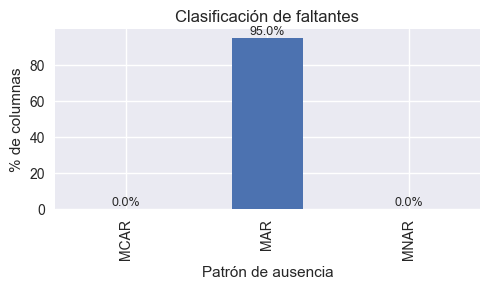

In [16]:
ax = (missing_classification['category']
      .value_counts(normalize=True)
      .reindex(['MCAR','MAR','MNAR'])
      .mul(100)
      .plot(kind='bar', figsize=(5,3)))
ax.set_ylabel('% de columnas'); ax.set_xlabel('Patrón de ausencia'); ax.set_title('Clasificación de faltantes')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x()+p.get_width()/2, p.get_height()+0.5),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()


## 2.2 Tratamiento de valores faltantes

Luego de analizar la cantidad, el patrón y la naturaleza de los valores faltantes, aplicamos una estrategia mixta de limpieza, eliminación e imputación justificada en función de la relevancia de cada variable y del tipo de información que aporta.

### 2.2.0 Eliminamos columnas irrelevantes (ID, URLs, texto libre o duplicado)

Estas columnas no aportan información útil al modelo o son difíciles de procesar sin técnicas NLP avanzadas. Ejemplos:

- Identificadores (id, scrape_id)
- URLs (listing_url, host_url, picture_url)
- Texto subjetivo o muy variable (name, description, host_about)
- Campos redundantes o visuales (host_thumbnail_url, host_picture_url, host_has_profile_pic)
- Fuente del scrape (source)

Estas columnas se eliminaron para simplificar el dataset y evitar ruido.

In [17]:
df = df.drop(columns=['id', 'listing_url','scrape_id','name','description','picture_url', 'host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_has_profile_pic','source'] )


### 2.2.1 Eliminamos columnas con más del 95% de nulos

- neighbourhood_group_cleansed (100% nulos)
- calendar_updated (100% nulos)
- license (99% nulos)

Estas columnas fueron eliminadas porque no contienen información útil para el problema.

In [18]:
df = df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated','license'] )

### 2.2.2 Tratamiento de columnas booleanas

- Si has_availability es nula, la completamos con yes si la suma de En lugar de eliminar, decidimos interpretar el significado del nulo:

    - has_availability:
        - Si está en nulo pero las columnas availability_30/60/90/365 suman > 0, significa que el alojamiento sí está disponible → lo completamos como 'yes'.
        - Si todas las disponibilidades son 0 → 'no'.
    - host_is_superhost
        - Si es nulo, no significa necesariamente “no”, sino “no evaluado aún”. Por eso creamos una nueva columna: was_evaluated_for_superhost = True/False

Luego imputamos host_is_superhost con 'yes'/'no'.

Además, estandarizamos todas las columnas booleanas a 'yes'/'no' para facilitar encoding posterior.

In [19]:
availability_cols = ['availability_30','availability_60','availability_90','availability_365']
availability_sum = df[availability_cols].sum(axis=1)
has_availability_isna = df['has_availability'].isna()
has_availability_true = (availability_sum != 0) & (has_availability_isna)
has_availability_false = (availability_sum == 0) & (has_availability_isna)

df.loc[has_availability_true,'has_availability'] = 't'
df.loc[has_availability_false,'has_availability'] = 'f'

df['was_evaluated_for_superhost'] = ~df['host_is_superhost'].isna()

boolean_cols = df.columns.intersection(
    ['host_has_profile_pic',
     'host_identity_verified',
     'instant_bookable',
     'has_availability','host_is_superhost'])

df.loc[:, boolean_cols] = df.loc[:, boolean_cols].replace({True: 'yes', False: 'no', 't': 'yes', 'f': 'no'})

df['host_is_superhost'] = df['host_is_superhost'].fillna('no')

print(df['host_is_superhost'].unique())
print(df['was_evaluated_for_superhost'].unique())


['yes' 'no']
[ True False]


### 2.2.3 Tratamiento de columnas de ubicación y texto corto

Columnas como:

- neighbourhood (52% nulos)
- neighbourhood_overview (52%)
- host_neighbourhood (46%)

En lugar de eliminarlas (pueden aportar señal geográfica):
- Completamos neighbourhood usando la versión limpia neighbourhood_cleansed.
- En neighbourhood_overview y host_neighbourhood, reemplazamos cadenas vacías o espacios por NA y luego imputamos con "not-defined".

Esto conserva la información geográfica, pero de forma controlada y consistente.

En resumen, nuestra estrategia no fue simplemente “eliminar nulos”, sino entender qué representa cada valor faltante y actuar en consecuencia:

- Eliminamos lo irrelevante o vacío.
- Estandarizamos e imputamos cuando el nulo tiene significado.
- Creamos nuevas variables para no perder información (ej. was_evaluated_for_superhost).

Esto prepara el dataset para una fase de imputación más fina o modelado sin fugas ni distorsiones.


In [20]:
df['neighbourhood'] = df['neighbourhood'].fillna(df['neighbourhood_cleansed'])

cols = ['neighborhood_overview', 'host_neighbourhood']
df[cols] = (
    df[cols]
      .astype('string')                         # cast a string nativo
      .replace(r'^\s*$', pd.NA, regex=True)     # "" o solo espacios → NA
      .fillna('not-defined')                    # completar NA
)

get_missing(df)


,missing,percent
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800
review_scores_checkin,5760,16.3800
last_review,5760,16.3800
review_scores_rating,5760,16.3800
review_scores_cleanliness,5760,16.3800
review_scores_communication,5760,16.3800
review_scores_location,5760,16.3800
first_review,5760,16.3800
reviews_per_month,5760,16.3800


### 2.2.4 Tratamiento de columnas de reviews

Observamos que todas las columnas relacionadas con reseñas tienen aproximadamente el mismo porcentaje de nulos (~16.7%).
Esto coincide con el hecho de que también faltan las fechas first_review y last_review, lo cual sugiere que esos listings nunca recibieron ninguna reseña.

Por lo tanto, los valores nulos no representan datos perdidos, sino ausencia lógica de reviews.
En consecuencia, aplicamos la siguiente estrategia:

1. Creamos una nueva variable binaria has_reviews_flag que indica si el listing tiene al menos una reseña o no.
2. Si el listing no tiene reseñas, asignamos 0 a todos los puntajes (review_scores_*).
3. Calculamos variables temporales más informativas:

- days_since_first_review
- days_since_last_review
(diferencia con last_scraped, por fila)

Si no hay reviews → asignamos -1, para diferenciar “nunca tuvo” de “tuvo hace mucho”.
4. Completamos reviews_per_month = 0 cuando no hay reseñas.
5. Finalmente eliminamos las columnas crudas first_review y last_review, porque ya generamos sus versiones numéricas y limpias.

Nos parecio una buena estrategia porque:

- No imputamos datos inventados → evitamos fuga de información.
- Preservamos significado → 0 puntajes = no hay reviews.
- Creamos nuevas features útiles para modelos
- Transformamos variables de fecha en valores numéricos fáciles de usar por cualquier algoritmo.

In [21]:
# ————————————————————————————————————————————————————————————————
# Reviews: normalización de scores y derivadas sin fuga
# Qué hace:
#   - Convierte review_scores_* a numérico
#   - Define has_reviews (0/1) y pone scores=0 si no hay reviews
#   - Crea días desde primera/última review usando last_scraped por fila
#   - Completa reviews_per_month=0 si no hay reviews
#   - Elimina fechas crudas de review
# ————————————————————————————————————————————————————————————————

review_score_columns = [c for c in df.columns if c.startswith("review_scores_")]
df[review_score_columns] = df[review_score_columns].apply(pd.to_numeric, errors='coerce')

has_any_review_count   = (df["number_of_reviews"] > 0)
has_first_review_date  = df["first_review"].notna()
has_last_review_date   = df["last_review"].notna()
has_reviews_per_month  = (df["reviews_per_month"].fillna(0) > 0)

df["has_reviews_flag"] = (
    has_any_review_count | has_first_review_date | has_last_review_date | has_reviews_per_month
).astype("int8")

# 3) si no hay reviews, los puntajes valen 0
if review_score_columns:
    df.loc[df["has_reviews_flag"] == 0, review_score_columns] = 0.0

# 4) días desde primera / última review (usando last_scraped por fila)
days_since_first_review = (df["last_scraped"] - df["first_review"]).dt.days
df["days_since_first_review"] = (
    days_since_first_review.where(df["has_reviews_flag"] == 1, -1)
                           .fillna(-1)
                           .clip(lower=-1)
                           .astype("int32")
)

days_since_last_review = (df["last_scraped"] - df["last_review"]).dt.days
df["days_since_last_review"] = (
    days_since_last_review.where(df["has_reviews_flag"] == 1, -1)
                          .fillna(-1)
                          .clip(lower=-1)
                          .astype("int32")
)

df.loc[(df["has_reviews_flag"] == 0) & (df["reviews_per_month"].isna()), "reviews_per_month"] = 0.0
df.drop(columns=["first_review", "last_review"], inplace=True)

get_missing(df)


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
estimated_revenue_l365d,3574,10.1600
price,3574,10.1600
bathrooms,3570,10.1500
beds,3568,10.1400
bedrooms,727,2.0700
bathrooms_text,24,0.0700
host_identity_verified,6,0.0200


### 2.2.5 Tratamiento para bathrooms_text, bedrooms, beds

La lógica para realizar el tratamiento de nulos de estas columnas es la siguiente: Las características como **room_type**, **bathrooms_text**, **bedrooms** y **beds** tienen cierto grado de relación natural. Es por eso que se pretende aprovechar esto para realizar el rellenado de los faltantes.

1. Paso 1: Se va a calcular la **MODA** de cada **room_type**. Luego a cada alojamiento que le falte **bathrooms_text**, se le va a asignar la **MODA** cuyo **room_type** sea el mismo. 

2. Paso 2: Una vez completados los nulos de **bathrooms_text**, se va a aprovechar esto para completar los nulos de **bedrooms**. Se va a calcular la **MODA** de cada **bathrooms_text**. Luego a cada alojamiento que le falte **bedrooms**, se le va a asignar la **MODA** cuyo **bathrooms_text** sea el mismo.

3. Paso 3: Una vez completados los nulos de **bedrooms**, se va a aprovechar esto para completar los nulos de **beds**. Se va a calcular la **MODA** de cada **bedrooms**. Luego a cada alojamiento que le falte **beds**, se le va a asignar la **MODA** cuyo **bedrooms** sea el mismo.


In [22]:
# remove_nan_1()
# 
# Entradas
#           df            DataFrame
#           nan_feature   Nombre de la feature que posee los nulos a reemplazar
#           ref_feature   Nombre de la feature sobre la cual calcular las modas
#
# Salida:
#           df            DataFrame actualizado
#
# El df recibido se modifica de manera de que se reemplazan todos los nulos encontrados
# en la columna nan_feature con las modas (previo dropeo de nan) calculadas para esa feature
# agrupando primero por ref_feature
#
# Ej: df = remove_nan_1(df, 'beds', 'bedrooms')
#
# 1) dropea los beds nan
# 2) agrupa las muestras por bedrooms y calcula la MODA de cada grupo
# 3) donde habia nan de beds le pone la MODA acorde al bedroom que pose esa muestra
def remove_nan_1(df, nan_feature, ref_feature):

    # Se pretende que la ref_feature no posea nan
    if len(df[df[ref_feature].isna()]) > 0:
      raise Exception(f'{ref_feature} posee nulos')
    
    _df = df.copy()

    # Si no hay nulos en nan_feature, no hace falta continuar  
    n_missing_before = len(df[df[nan_feature].isna()])
    if n_missing_before == 0:
        print(f"No hay faltantes de {nan_feature}")
        return _df
    
    # Dropear los nan
    _df_no_nan = _df.dropna(subset=[nan_feature])
    
    # Calcular la moda usando ref_feature
    moda = _df_no_nan.groupby(ref_feature)[nan_feature].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Reemplazar
    _df.loc[_df[nan_feature].isna(), nan_feature] = _df.loc[_df[nan_feature].isna(), ref_feature].map(moda)
    n_faltantes_after = len(_df[_df[nan_feature].isna()])
    print(f"Numero de faltantes de {nan_feature}: antes={n_missing_before}, despues={n_faltantes_after}")
    
    # Si aun quedan nulos significa que no hubo match exacto entre las posibles modas y el valor de una cierta
    # fila
    nan_indices = _df[_df[nan_feature].isna()].index
    for index in nan_indices:
      v = _df.loc[index, ref_feature]
      idx_min = 0
      min = abs(v - moda.loc[idx_min])
      for idx_m, value_m in moda.items():
        d = abs(v - value_m)
        if d < min:
          idx_min = idx_m
          min = d
      _df.loc[index, nan_feature] = moda.loc[idx_min]
      print(f"valor original no encontrado: {v}, valor usado: {moda.loc[idx_min]}, indice: {idx_min}")
      print(f"Numero de faltantes de {nan_feature}: antes={n_missing_before}, despues={len(_df[_df[nan_feature].isna()])}")
    return _df

In [23]:
df = remove_nan_1(df, nan_feature = 'bathrooms_text', ref_feature = 'room_type')
df = remove_nan_1(df, nan_feature = 'bedrooms', ref_feature = 'bathrooms_text')
df = remove_nan_1(df, nan_feature = 'beds', ref_feature = 'bedrooms')

get_missing(df)

Numero de faltantes de bathrooms_text: antes=24, despues=0
Numero de faltantes de bedrooms: antes=727, despues=0
Numero de faltantes de beds: antes=3568, despues=1
valor original no encontrado: 35.0, valor usado: 30.0, indice: 19.0
Numero de faltantes de beds: antes=3568, despues=0


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
host_listings_count,6,0.0200
host_identity_verified,6,0.0200
host_total_listings_count,6,0.0200
host_verifications,6,0.0200


### 2.2.6 Antigüedad del host (feature engineering)

La antigüedad del host puede influir en el rendimiento del anuncio: los hosts nuevos suelen tener menos reseñas y menor confianza por parte de los usuarios, mientras que los hosts establecidos tienden a ser más consistentes.

Para capturar esta señal creamos la variable host_days_active, calculada como:

- host_days_active = last_scraped − host_since

Es decir, cuántos días lleva el host activo en la plataforma hasta la fecha del scrape (fecha “hoy” del dataset).

- Si la fecha no está disponible, completamos con -1 para marcar “desconocido” sin confundirlo con 0 días.
- Luego creamos un flag host_is_new = 1 si la antigüedad está entre 0 y 89 días (≈ 3 meses), rango típico en el cual los nuevos hosts todavía no tienen reputación consolidada ni mucha demanda.

Estas variables nos permiten modelar diferencias de comportamiento entre hosts nuevos vs. experimentados, sin usar información futura (evitando data leakage).

In [24]:
df['host_days_active'] = (df['last_scraped'] - df['host_since']).dt.days
df['host_days_active'] = df['host_days_active'].fillna(-1).astype('int32')

df['host_is_new'] = (df['host_days_active'] >= 0) & (df['host_days_active'] < 90)
df['host_is_new'] = df['host_is_new'].astype('int8')



### 2.2.7 Chequeo de nulos antes del split

Luego de aplicar todas las transformaciones anteriores (eliminación, imputación selectiva y creación de nuevas variables), volvemos a revisar los valores faltantes para saber qué columnas siguen teniendo nulos y en qué proporción.

Este paso es clave por dos razones:

- Nos asegura que ya eliminamos los nulos “estructurales” o irrelevantes.
- Nos muestra qué variables requieren imputación final, que haremos después del split para evitar fuga de información.

Los nulos que permanecen ahora corresponden principalmente a:

- Métricas de respuesta del host (response_time, response_rate, acceptance_rate)
- Price y estimated_revenue_l365d (que imputaremos con métodos más apropiados como media / mediana / MICE)
- Algunas variables numéricas o categóricas aisladas

Estos nulos serán tratados más adelante en el pipeline, ya dentro del conjunto de entrenamiento.

In [25]:
get_missing(df)


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
host_listings_count,6,0.0200
host_verifications,6,0.0200
host_total_listings_count,6,0.0200
host_identity_verified,6,0.0200


## 2.3 Split del dataset (evitando data leakage)

Antes de entrenar cualquier modelo, separamos los datos en train (80%) y test (20%).
Sin embargo, no usamos un train_test_split tradicional, porque un mismo host puede tener varios listings.
Si un mismo host_id aparece en train y en test, el modelo podría “reconocer” información del host en el test aunque nunca lo haya visto explícitamente → esto genera data leakage. Para evitarlo, usamos GroupShuffleSplit, que garantiza que todos los listings del mismo host queden en el mismo conjunto (o solo en train o solo en test).

In [26]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['host_id']))

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# sanity check: no hay host_id compartidos
assert set(df_train.host_id) & set(df_test.host_id) == set()

print(df.shape, df_test.shape, df_train.shape)

df_train.drop(columns=['host_id'], inplace=True)
df_test.drop(columns=['host_id'], inplace=True)

(35172, 66) (6988, 66) (28184, 66)


In [27]:
df_train.head(1)

,last_scraped,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,was_evaluated_for_superhost,has_reviews_flag,days_since_first_review,days_since_last_review,host_days_active,host_is_new
1,2025-01-30,Palermo is such a perfect place to explore the...,2016-08-03,within an hour,100%,100%,no,not-defined,7.0000,16.0000,"['email', 'phone']",yes,"Palermo/Buenos Aires, Autonomous City of Bueno...",Palermo,-34.5862,-58.4104,Entire rental unit,Entire home/apt,2,1.0000,1 bath,1.0000,1.0000,"[""Bathtub"", ""Air conditioning"", ""TV"", ""Heating...",22375.0000,7,40,7,7,1125,1125,7.0000,1125.0000,yes,13,43,44,44,2025-01-30,123,8,1,44,8,112,2506000.0000,4.7700,4.7600,4.7700,4.8200,4.9000,4.8700,4.7500,no,6,6,0,0,0.8000,True,1,4587,12,3102,0


## 3. Distribuciones y visualizaciones clave


### 3.1 Distribucion de precios

La variable price es una de las más importantes del dataset, pero su distribución está altamente sesgada a la derecha (right-skewed), con algunos valores extremos muy altos.

Para analizarla correctamente hacemos dos visualizaciones complementarias:

1) Distribución completa (todas las observaciones)

- Mostramos el histograma original sin filtros.
- Conclusión: la mayoría de los precios se concentran en valores bajos, pero existen algunos outliers extremos que “aplastan” la escala y dificultan ver la forma real de la distribución.

2) Distribución recortada (≤ percentil 99)

Aplicamos un corte en el percentil 99 para visualizar el comportamiento del 99% de los casos típicos, sin que los outliers dominen la escala.

- Ahora la distribución se ve más claramente.
- La mediana está alrededor de 50 USD.
- Se observa un sesgo moderado, lo cual sugiere que una transformación logarítmica o capado/winsorize podría ser útil en el modelado.

Este analisis es importante porque:

- Nos permite detectar outliers y decidir si recortarlos o caparlos.
- Entendemos la forma de la variable para elegir técnicas adecuadas.
- Evitamos que unos pocos valores extremos distorsionen el modelo.

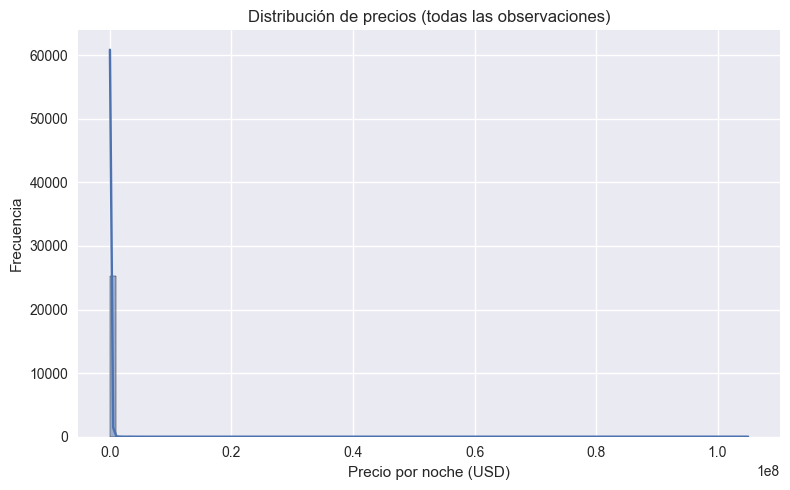

In [28]:
sns.histplot(df_train['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


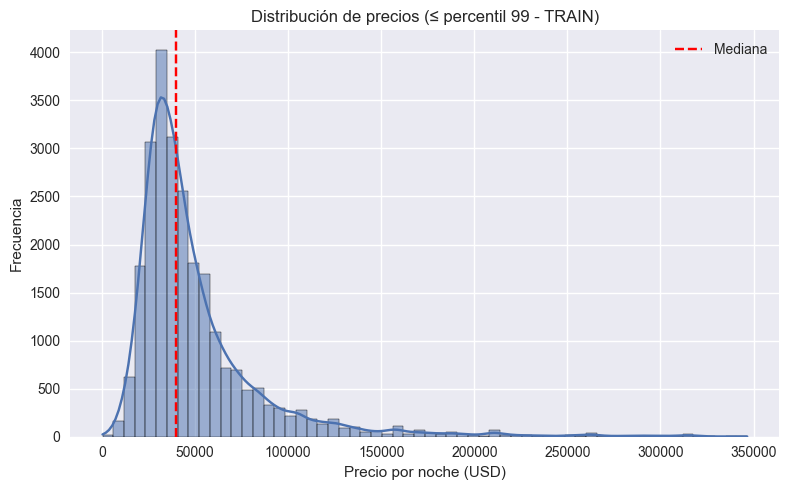

In [29]:
p99_price = df_train['price'].quantile(0.99)

mask_train = df_train['price'] <= p99_price
price_train_p99 = df_train.loc[mask_train, 'price'].dropna()

sns.histplot(price_train_p99, bins=60, kde=True)
plt.axvline(df_train['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (≤ percentil 99 - TRAIN)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()


- La asimetría extrema (skewness > 50) indica que la mayoría de los precios están concentrados en valores bajos, pero existen algunos listados con precios extremadamente altos. Esto puede afectar los modelos si no se trata.
- Después de aplicar log1p, la asimetría baja a 1.7, lo cual indica que la distribución se acerca más a una forma aproximadamente normal y será más fácil de modelar.

In [30]:
# Skewness de precios para evaluar la asimetría
price_series = df_train['price'].dropna()
price_skew = price_series.skew()
positive_prices = price_series[price_series > 0]
price_log_skew = np.log1p(positive_prices).skew() if not positive_prices.empty else np.nan
print(f'Skewness (precio bruto): {price_skew:.3f}')
print(f'Skewness (log1p del precio): {price_log_skew:.3f}')


Skewness (precio bruto): 52.733
Skewness (log1p del precio): 1.780


- Los departamentos/entire home tienen precios generalmente más altos y mayor dispersión. Las habitaciones privadas y compartidas tienen distribuciones más acotadas. Esto sugiere que room_type es una variable muy relevante para el precio

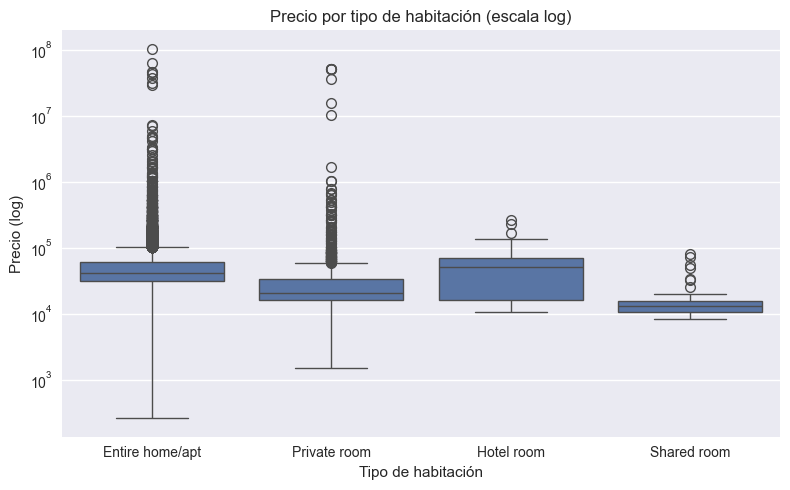

In [31]:
sns.boxplot(data=df_train, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


- A mayor capacidad, el precio tiende a aumentar, pero con mucha variabilidad. Esto indica que la capacidad influye, pero no es el único factor determinante. Además, se ve que distintos room_type ocupan rangos de precio diferentes incluso con la misma capacidad.

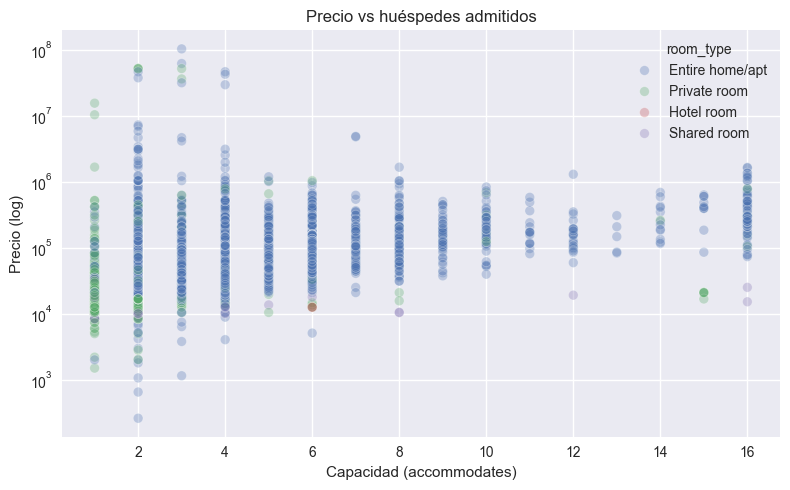

In [32]:
# Precio versus capacidad
sns.scatterplot(data=df_train, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


Estas visualizaciones nos ayudan a entender qué variables tienen relación con el precio, dónde hay outliers y qué transformaciones serán útiles antes de entrenar modelos.

### 3.2 Auditoría del target (¿está “contaminado” por disponibilidad o reviews?)

Este bloque verifica si nuestra variable objetivo estimated_occupancy_l365d está implícitamente derivada de señales que no podemos usar en cold-start (p. ej., availability_365 o métricas de reviews). La idea es detectar fuga de información (data leakage) antes de modelar.

El objetivo del siguiente codigo es el siguiente:

- Comparación con disponibilidad anual
    - Calcula approx = 1 - availability_365/365 (una ocupación “aproximada” a partir de la disponibilidad).
    - Imprime:
        - corr(y, 1 - avail/365): correlación entre el target y esa aproximación.
        - max abs diff: máxima diferencia absoluta entre y y approx.
    - Interpretación:
        - Si la correlación es muy alta (≈0.9–1.0) y las diferencias son mínimas, el target podría estar derivado de availability ⇒ no usar availability como feature y cuestionar si el target es realmente independiente.

- Correlación del target con señales de reviews
    - Evalúa la correlación de y con number_of_reviews, reviews_per_month, has_reviews y days_since_last_review.
    - Interpretación:
       - Correlaciones altas sugieren que el target está fuertemente explicado por historial de reseñas. Para un escenario cold-start, estas columnas deben excluirse de las features (aunque el target siga siendo válido).

- Podemos observar que:
    - Si Si corr(y, 1 - avail/365) es alta o max abs diff ≈ 0 → el target está prácticamente codificando disponibilidad. Se tiene que evitar por completo availability_* y derivados en el modelo.
    - Si hay altas correlaciones con reviews → confirma que en el pipeline de features las columnas de reviews no deben entrar (y se debe documentar que el target depende de comportamiento histórico, que un nuevo listing no tiene).

Nuestro objetivo final es asegurarnos de que el target que vamos a predecir no esté “mirando el futuro” y que las features del modelo sean válidas para un listing nuevo. Esto evita resultados artificialmente perfectos por fuga.

Resultado observado:

- reviews_per_month ≈ 0.76
- number_of_reviews ≈ 0.57
- Varios review_scores_* ≈ 0.37 – 0.38

Estas correlaciones son altas y significativas, lo que sugiere que el target está fuertemente influenciado por el historial de reseñas.

Del analisis podemos concluir que:

- El target es válido (no es un cálculo directo de availability).
- Pero está muy correlacionado con datos de reviews, que NO están disponibles para listings nuevos. Por lo tanto, debemos excluir todas las columnas basadas en reviews en el conjunto de features para evitar data leakage, especialmente si queremos predecir ocupación/disponibilidad en listings nuevos

In [33]:
y_days  = pd.to_numeric(df['estimated_occupancy_l365d'], errors='coerce').astype(float)
y_rate  = (y_days / 365).clip(0, 1)

if 'availability_365' in df.columns:
    approx_rate = 1 - (df['availability_365'] / 365)
    corr = y_rate.corr(approx_rate)
    max_abs_diff = np.nanmax(np.abs(y_rate - approx_rate))
    mae = np.nanmean(np.abs(y_rate - approx_rate))
    print(f"corr(rate, 1 - avail/365) = {corr:.3f} | max abs diff (rate) = {max_abs_diff:.3f} | MAE = {mae:.3f}")

# --- auditoría de correlaciones del target con señales de reviews
def audit_target_source(df: pd.DataFrame, ycol: str = 'estimated_occupancy_l365d'):
    y_rate = (pd.to_numeric(df[ycol], errors='coerce').astype(float) / 365).clip(0, 1)

    report = {}
    if 'availability_365' in df.columns:
        report['corr_with_1_minus_availability'] = y_rate.corr(1 - df['availability_365'] / 365)

    review_like_cols = [
        'number_of_reviews', 'reviews_per_month', 'has_reviews', 'days_since_last_review',
        *[c for c in df.columns if c.startswith('review_scores_')]
    ]

    report.update({
        f'corr_with_{col}': y_rate.corr(pd.to_numeric(df[col], errors='coerce'))
        for col in review_like_cols if col in df.columns
    })

    return dict(sorted(report.items(), key=lambda kv: abs(kv[1]), reverse=True))

report = audit_target_source(df)

corr_df = (
    pd.Series(report, name='corr')
      .rename_axis('feature')
      .reset_index()
      .assign(abs_corr=lambda d: d['corr'].abs())
      .sort_values('abs_corr', ascending=False)
      .drop(columns='abs_corr')
)

corr_df


corr(rate, 1 - avail/365) = -0.029 | max abs diff (rate) = 1.000 | MAE = 0.376


,feature,corr
0,corr_with_reviews_per_month,0.7617
1,corr_with_number_of_reviews,0.5707
2,corr_with_review_scores_value,0.3783
3,corr_with_review_scores_cleanliness,0.3748
4,corr_with_review_scores_rating,0.3733
5,corr_with_review_scores_accuracy,0.3713
6,corr_with_review_scores_communication,0.3680
7,corr_with_review_scores_checkin,0.3651
8,corr_with_review_scores_location,0.3643
9,corr_with_days_since_last_review,-0.2619


### 3.3 Distribuciones de ocupación

Con el histograma y el resumen estadístico observamos:

- Rango (días/año): mínimo = 0, Q1 = 0, mediana = 28, Q3 = 96, máximo = 255.
- En términos de tasa: media ≈ 61/365 ≈ 0.17 (17%).
- Hay un pico fuerte cerca de 0.7 (= 255/365) → esto confirma que hay top-coding / censura superior en 255 días (los listings con >255 días de ocupación fueron truncados y quedan “apilados” ahí
- También hay muchos valores en 0 (Q1=0) → muchos alojamientos no tienen ocupación estimada.

¿Qué implica esto para el modelado?

La distribución está muy sesgada (skewed).

- Hay masa en 0 → comportamiento de “no alquila nada”.
- Hay censura por arriba (255) → no sabemos el valor real si supera el tope.
- Una regresión directa sobre días/365 sufriría por el techo y la asimetría.

Por eso, consideramos que puede ser más robusto tratar el problema como clasificación por tramos de ocupación, en lugar de regresión directa sobre un valor continuo.

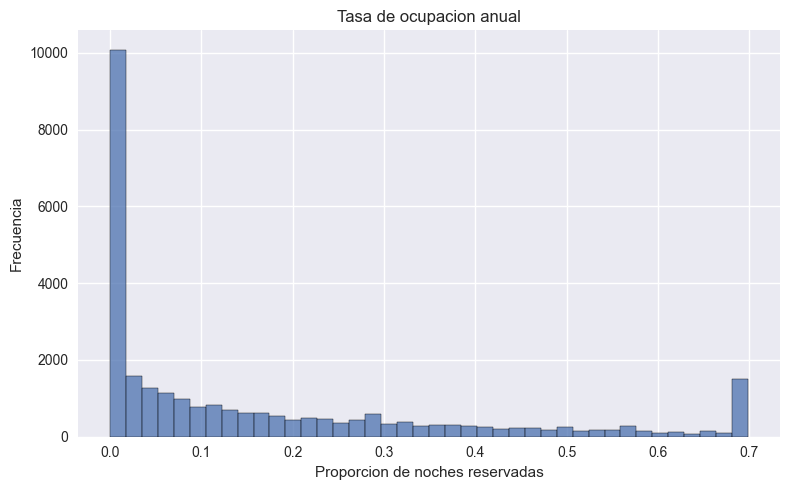

(count   28184.0000
 mean       60.9655
 std        76.0503
 min         0.0000
 25%         0.0000
 50%        28.0000
 75%        96.0000
 max       255.0000
 Name: estimated_occupancy_l365d, dtype: float64,
 255,
 1413,
 0.050134828271359635)

In [34]:
sns.histplot(df_train['estimated_occupancy_l365d']/365, bins=40, kde=False)
plt.title('Tasa de ocupacion anual')
plt.xlabel('Proporcion de noches reservadas')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

s = df_train['estimated_occupancy_l365d']
s.describe(), s.max(), (s==255).sum(), (s>=255).mean()


### 3.3 Distribuciones de disponibilidad (1 - ocupacion)

Si analizamos la proporción de noches disponibles (1 - ocupación):

- La mayoría de los listings tienen más del 90 % de disponibilidad.
- Hay un pico muy pronunciado en 1.0, lo que indica que muchos alojamientos no recibieron ninguna reserva durante el año (disponibles todo el tiempo).
- La distribución es extremadamente sesgada hacia valores altos, lo que es el reflejo inverso del sesgo en la ocupación.

Esta visualización confirma dos cosas importantes:

- La variable objetivo está altamente desbalanceada.
- Muchos listings tienen ocupación 0 o muy baja, lo que refuerza la idea de que un modelo de regresión directa tendría problemas (predominan los ceros).

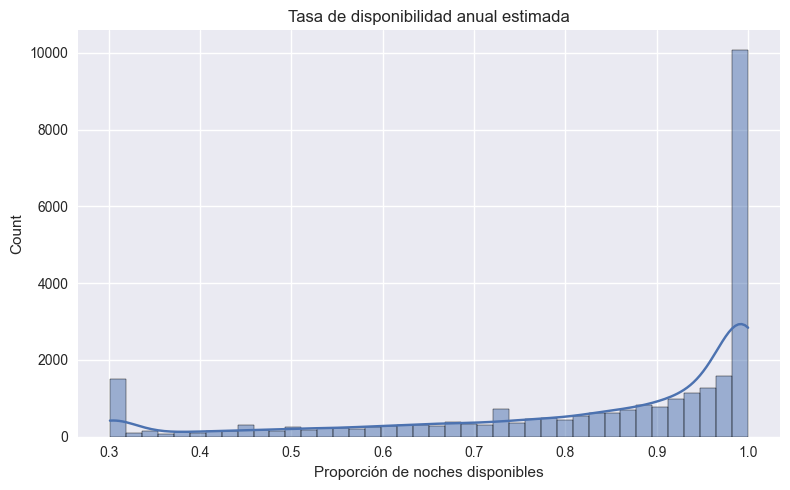

In [35]:
sns.histplot(1 - (df_train['estimated_occupancy_l365d'] / 365), bins=40, kde=True)
plt.title('Tasa de disponibilidad anual estimada')
plt.xlabel('Proporción de noches disponibles')
plt.tight_layout()
plt.show()


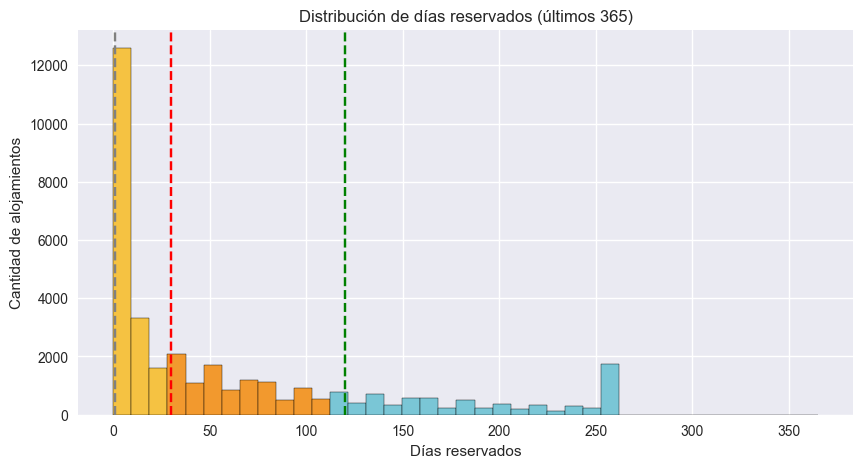

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Días reservados (0–365)
occ_days = pd.to_numeric(df['estimated_occupancy_l365d'], errors='coerce').clip(0, 365)

# 2) Porcentajes por categoría (sobre valores válidos)
n = occ_days.notna().sum()
pct_zero = (occ_days.eq(0)).mean() * 100
pct_low  = ((occ_days.between(1, 30))).mean() * 100
pct_mid  = ((occ_days.between(31, 120))).mean() * 100
pct_high = ((occ_days.ge(121))).mean() * 100

# 3) Histograma con colores por rango (bins finos)
valid = occ_days.dropna()
bins = np.linspace(0, 365, 40)  # podés ajustar la resolución
counts, edges = np.histogram(valid, bins=bins)

def bin_color(lo, hi):
    if hi <= 1:
        return '#BFBFBF'       # zero (gris)
    elif hi <= 30:
        return '#F5C242'       # low (amarillo)
    elif hi <= 120:
        return '#F2992E'       # mid (naranja)
    else:
        return '#7AC6D6'       # high (celeste)

colors = [bin_color(edges[i], edges[i+1]) for i in range(len(edges)-1)]

# 4) Plot
plt.figure(figsize=(10,5))
plt.bar(edges[:-1], counts, width=np.diff(edges), align='edge',
        color=colors, edgecolor='black')

# Líneas guía en los cortes (1, 30, 120)
plt.axvline(1,   color='grey',  ls='--', label='1 día')
plt.axvline(30,  color='red',   ls='--', label='30 días')
plt.axvline(120, color='green', ls='--', label='120 días')

plt.title('Distribución de días reservados (últimos 365)')
plt.xlabel('Días reservados')
plt.ylabel('Cantidad de alojamientos')

# 5) Texto con porcentajes
txt = (f'zero (0): {pct_zero:.1f}%   |   low (1–30): {pct_low:.1f}%   |   '
       f'mid (31–120): {pct_mid:.1f}%   |   high (121–365): {pct_high:.1f}%')


### 3.4 - Correlación orientada a disponibilidad (categóricas codificadas)

Hasta ahora analizamos la distribución del target y comprobamos que no está “contaminado” por disponibilidad.
El siguiente paso es entender qué variables explican mejor la ocupación, pero sin provocar fuga de información (data leakage).

Para eso:

- Convertimos el target a tasa de ocupación (occupancy_days / 365)
- Excluimos completamente las columnas de disponibilidad (availability_*)
- Si estamos en un escenario cold-start, también excluimos columnas basadas en reviews (porque un nuevo listing no tiene reseñas)
- Seleccionamos un conjunto de variables numéricas y categóricas relevantes
- Aplicamos one-hot encoding a las categóricas
- Calculamos la correlación de Pearson entre cada feature y la tasa de ocupación
- Visualizamos las Top N más correlacionadas mediante un heatmap

Este análisis nos permite detectar en qué dimensiones (ubicación, tipo de propiedad, características del host, capacidad, políticas, etc.) se concentra la señal predictiva real sin depender de información futura o derivada del target.

/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_88735/3997241987.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_88735/3997241987.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_88735/3997241987.py:38: FutureWarning: Downcasting behavior in `replace` is dep

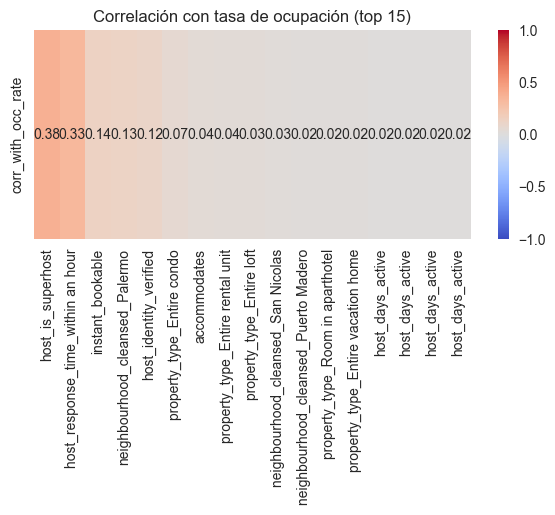

,corr_with_occ_rate
host_is_superhost,0.3802
host_response_time_within an hour,0.3347
instant_bookable,0.1374
neighbourhood_cleansed_Palermo,0.1280
host_identity_verified,0.1159
...,...
property_type_Private room in home,-0.0812
property_type_Private room in rental unit,-0.0874
host_response_time_within a day,-0.1054
host_response_time_within a few hours,-0.1145


In [37]:
def corr_vs_occupancy(df, target_col='estimated_occupancy_l365d', cold_start=True, topk=15):
    """
    Calcula correlación (Pearson) de features con la tasa de ocupación (target_col/365),
    evitando leakage (excluye availability_* y derivados). No muta df.
    Si cold_start=True, también excluye features basadas en reviews.
    """

    df_ = df.copy()
    y = (df_[target_col] / 365.0).astype(float)

    # Excluimos las columnas de availability por leakage / circularidad
    leak_cols = [c for c in df_.columns if c.startswith('availability_')] + ['has_availability']

    # Excluimos columnas de reviews por la correlatividad con el target
    review_cols = set()
    if cold_start:
        review_cols |= {c for c in df_.columns if c.startswith('review_scores_')}
        review_cols |= {c for c in df_.columns if c.startswith('number_of_reviews')}
        review_cols |= {'reviews_per_month', 'has_reviews',
                        'days_since_first_review', 'days_since_last_review'}

    drop_cols = set(leak_cols) | review_cols

    base_num = ['accommodates','bedrooms','beds','minimum_nights','maximum_nights',
                'price_imputed','bathrooms','host_response_rate','host_acceptance_rate',
                'host_days_active','amenities_count','price_per_person', 'host_days_active', '']

    base_cat = ['room_type','property_type','neighbourhood_cleansed',
                'instant_bookable','host_is_superhost','host_identity_verified','host_is_new','was_evaluated_for_superhost'
                'bathroom_is_shared','host_response_time']

    num_cols = [c for c in base_num if c in df_.columns and c not in drop_cols]
    cat_cols = [c for c in base_cat if c in df_.columns and c not in drop_cols]

    bin_like = ['instant_bookable','host_is_superhost','host_identity_verified','bathroom_is_shared','host_is_new', 'was_evaluated_for_superhost']
    for c in [c for c in bin_like if c in df_.columns]:
        df_[c] = (df_[c].astype(str).str.lower()
                  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
                  .astype('float'))

    X_num = df_[num_cols].apply(pd.to_numeric, errors='coerce')
    X_cat = pd.get_dummies(df_[cat_cols], drop_first=True, dtype=float) if cat_cols else pd.DataFrame(index=df_.index)
    X = pd.concat([X_num, X_cat], axis=1)
    X = X.loc[:, X.std(numeric_only=True) > 0].dropna(axis=1, how='all')

    corr = X.corrwith(y).sort_values(ascending=False)
    corr_df = corr.to_frame(name='corr_with_occ_rate')

    top = corr_df['corr_with_occ_rate'].abs().head(topk).index
    plt.figure(figsize=(6, max(3, 0.35*len(top))))
    sns.heatmap(corr_df.loc[top].T, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f'Correlación con tasa de ocupación (top {topk})')
    plt.tight_layout(); plt.show()

    return corr_df.sort_values('corr_with_occ_rate', ascending=False)


corr_vs_occupancy(df_train)

Los resultados muestran que no hay una única variable que explique por completo la ocupación, sino varios factores moderadamente relevantes. Las correlaciones más altas permiten entender qué características aportan demanda sostenida.

1. Factores del host
- host_is_superhost (~0.38) → Es el predictor más fuerte. Los superhosts tienden a tener más ocupación constante.
- host_response_time_within_an_hour (~0.33) → La velocidad de respuesta del host importa: la inmediatez atrae reservas.
- host_identity_verified (~0.12) → La confianza en el host también aporta, aunque menos.

la reputación y profesionalismo del host influye mucho en la ocupación.

2. Factores del proceso de reserva
- instant_bookable (~0.14) → Permitir reservas inmediatas reduce fricción y aumenta ocupación.

3. Ubicación
- neighbourhood_cleansed_Palermo (~0.13). Algunas zonas específicas explican mayor ocupación, especialmente Palermo.

4. Tipo de propiedad
- Entire condo / Entire rental unit / Entire loft (~0.04–0.05)
- Room in apartment / Entire vacation home (~0.02)

Las propiedades completas tienen mayor ocupación.

5. Capacidades y características estructurales

- accommodates (~0.04) → A mayor capacidad, mayor ocupación (pero moderado efecto).
- host_days_active (~0.02) → Más antigüedad también ayuda (hosts con experiencia).

#### Conclusión general

- La ocupación no parece depender de una sola variable, sino de una combinación de reputación del host + facilidad de reserva + ubicación + tipo de propiedad.
- Los mejores predictores son del host y del proceso de reserva, lo que sugiere que la “calidad percibida” del listing es clave.
- La correlación moderada (<0.4) indica que probablemente modelos no lineales o interacciones entre variables capturen mucho más.


## 4. Definición del objetivo (ocupación anual discretizada)

Dividimos los días reservados en el último año (estimated_occupancy_l365d) en cuatro rangos:

- zero: 0 días
- low: 1–30 días (≈ 0–8% de ocupación anual)
- mid: 31–120 días (≈ 8–33%)
- high: 121–365 días (≈ 33–100%)

La distribución por clases quedó similar entre TRAIN y TEST (aprox.):

- TRAIN →
    - zero ~29.7%,
    - low ~23.8%,
    - mid ~27.0%,
    - high ~19.5%
- TEST →
    - zero ~26.9%,
    - low ~23.5%,
    - mid ~29.7%,
    - high ~19.9%

Decisión: trabajamos como clasificación multiclase (variable occupancy_level) en lugar de regresión directa.
Motivos:
 - la variable de días está censurada en 255 y muy sesgada con masa en 0;
 - los cortes definen niveles interpretables para negocio (baja/media/alta) evitando extrapolación sobre outliers.

Además, no usamos variables de disponibilidad futura ni derivados para evitar fuga de información. El objetivo es predecir el nivel de ocupación con atributos disponibles al momento de publicar el anuncio.

In [38]:
# Clases por número de noches reales
occ_tr = df_train['estimated_occupancy_l365d'].clip(lower=0, upper=365)
occ_te = df_test['estimated_occupancy_l365d'].clip(lower=0, upper=365)

bins   = [-1, 0, 30, 120, 366]
labels = ['zero','low','mid','high']

df_train['occupancy_level'] = pd.cut(occ_tr, bins=bins, labels=labels, right=True, include_lowest=True)
df_test['occupancy_level']  = pd.cut(occ_te, bins=bins, labels=labels, right=True, include_lowest=True)

print("TRAIN %:\n", df_train['occupancy_level'].value_counts(normalize=True).sort_index().round(3))
print("TEST %:\n",  df_test['occupancy_level'].value_counts(normalize=True).sort_index().round(3))
print("Cortes usados (días):", bins)


TRAIN %:
 occupancy_level
zero   0.2970
low    0.2380
mid    0.2700
high   0.1950
Name: proportion, dtype: float64
TEST %:
 occupancy_level
zero   0.2690
low    0.2350
mid    0.2970
high   0.1990
Name: proportion, dtype: float64
Cortes usados (días): [-1, 0, 30, 120, 366]


## 5. Planteo del problema supervisado
Planteamos un problema de clasificación multiclase donde la variable target es occupancy_level, construida a partir de la ocupación estimada en días del último año (estimated_occupancy_l365d). Para evitar ambigüedades de cuantiles y mantener interpretabilidad, discretizamos por umbrales en días:

- zero: 0 noches/año
- low: 1–30 noches/año
- mid: 31–120 noches/año
- high: > 120 noches/año (máximo observado ≈255 noches por top-coding de la fuente)

Estos cortes representan niveles de demanda con significado operativo (no dependen de la disponibilidad futura) y se aplican tanto en train como en test.

Objetivo.

- Anticipar la categoría de ocupación (zero/low/mid/high) usando solo atributos disponibles al publicar un listing (es decir, sin señales de calendario futuro ni derivados directos de disponibilidad).
- Evitar fuga de información.
- Excluimos de las features todas las columnas availability_* y has_availability.

Como el target proviene de reseñaes históricas (reviews), ofrecemos dos configuraciones:

Cold-start (recomendada): excluir features basadas en reviews (number_of_reviews, reviews_per_month, days_since_*, etc.) para que el modelo sea aplicable a listings nuevos.
Con historial: incluir dichas variables, declarando explícitamente la dependencia con el pasado.

Conjunto de features (ejemplos, sin leakage):

- Ubicación: latitude, longitude, neighbourhood_cleansed
- Configuración: room_type, property_type, accommodates, bedrooms, beds, bathrooms
- Precio: price
- Host: host_days_active (antigüedad), host_is_superhost, instant_bookable, host_identity_verified, host_response_rate, host_acceptance_rate
- Amenidades: amenities_count y flags clave (p. ej., wifi/AC/workspace)

Métricas. Reportamos F1 macro, balanced accuracy y matriz de confusión para evaluar desempeño por clase (incluyendo la clase zero, que representa ~30% de los casos). En caso de desbalance residual entre clases, se emplea class_weight='balanced' y se consideran umbrales de decisión ajustados.


### 5.1 Codificación de amenities

Normalizamos la columna JSON de `amenities`, homogenizamos etiquetas y generamos indicadores binarios para las 20 amenidades más frecuentes; estas columnas (`amenity_*`) amplían el set de features con información interpretable.


In [39]:
import re, json, ast

def normalize_amenities(value):
    if pd.isna(value):
        return []
    text = str(value).strip()
    if not text:
        return []
    candidate = text.replace('{', '[').replace('}', ']')
    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        try:
            parsed = ast.literal_eval(candidate)
        except (ValueError, SyntaxError):
            parsed = [item.strip() for item in candidate.strip('[]').split(',')]
    normalized = []
    for item in parsed:
        token = str(item).strip().strip('"').strip("'")
        if token:
            normalized.append(token.lower())
    return sorted(set(normalized))

# --- TRAIN: listas y top-k ---
amenity_lists = df_train['amenities'].apply(normalize_amenities)
amenity_counts = amenity_lists.explode().value_counts()

df_train['amenities_count'] = amenity_lists.str.len().astype('int16')

top_k = 20
top_amenities = amenity_counts.head(top_k)

def amenity_to_col(amenity):
    slug = re.sub(r'[^a-z0-9]+', '_', amenity).strip('_')
    return f'amenity_{slug}' if slug else 'amenity_other'

amenities_feature_cols = []
for amenity in top_amenities.index:
    base_name = amenity_to_col(amenity)
    name = base_name
    suffix = 1
    while name in amenities_feature_cols:
        suffix += 1
        name = f"{base_name}_{suffix}"
    amenities_feature_cols.append(name)
    df_train[name] = amenity_lists.apply(lambda items, target=amenity: int(target in items)).astype('int8')

# --- TEST: aplicar exactamente el vocab de TRAIN ---
amenity_lists_test = df_test["amenities"].apply(normalize_amenities)

#
df_test['amenities_count'] = amenity_lists_test.str.len().astype('int16')

for amenity, col_name in zip(top_amenities.index, amenities_feature_cols):
    df_test[col_name] = amenity_lists_test.apply(lambda items, target=amenity: int(target in items)).astype('int8')

# asegura que TODAS las cols de train existan en test
for col in amenities_feature_cols:
    if col not in df_test.columns:
        df_test[col] = 0
    df_train[col] = df_train[col].astype('int8')
    df_test[col]  = df_test[col].astype('int8')

df_train.drop(columns=['amenities'], inplace=True)
df_test.drop(columns=['amenities'], inplace=True)


### 5.2 Imputaciones

En esta parte empezamos a manejar los valores faltantes.  
Algunos campos del dataset tienen muchos nulos (por ejemplo, respuestas del host o ratings).  
Si no los tratamos, los modelos directamente no van a poder entrenar.  
Primero analizamos qué columnas tienen más datos faltantes y pensamos una estrategia para completarlas sin romper la consistencia general.  
En esta sección se van a definir las funciones y reglas básicas que se usarán para las imputaciones.

- Detectamos valores de price iguales a 0 o negativos (precios inválidos).
- Reemplazamos esos valores con la mediana de los precios positivos para no distorsionar la distribución.
- Creamos una columna price_imputed, que luego será escalada con MinMaxScaler dentro del pipeline (manteniendo la versión original si se requiere para interpretación).

In [40]:
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def normalize_missing(series: pd.Series) -> pd.Series:
    mask = series.isna()
    mask |= series.astype(str).str.strip().isin(NULL_TOKENS)
    return series.mask(mask, pd.NA)

def to_numeric_price(series: pd.Series) -> pd.Series:
    cleaned = (
        series.astype(str)
              .str.replace(r"[^\d\.]", "", regex=True)
              .replace("", pd.NA)
    )
    return pd.to_numeric(cleaned, errors="coerce")

df_train["price_clean"] = to_numeric_price(normalize_missing(df_train["price"]))
df_test["price_clean"] = to_numeric_price(normalize_missing(df_test["price"]))

df_train["price_was_missing"] = df_train["price_clean"].isna().astype("int8")
df_test["price_was_missing"]  = df_test["price_clean"].isna().astype("int8")

# Estadísticos aprendidos SOLO con df_train
global_price_median = df_train["price_clean"].median()

median_price_by_group = (
    df_train.groupby(["neighbourhood_cleansed", "room_type"])["price_clean"]
            .median()
            .dropna()
)

median_price_by_neighbourhood = (
    df_train.groupby("neighbourhood_cleansed")["price_clean"]
            .median()
            .dropna()
)

def add_price_per_person(df: pd.DataFrame) -> pd.DataFrame:
    accommodates = df['accommodates'].replace(0, pd.NA).fillna(1)
    df['price_per_person'] = df['price_imputed'] / accommodates

    df['price_per_person'] = df['price_per_person'].replace([pd.NA, np.inf, -np.inf], np.nan)
    df['price_per_person'] = df['price_per_person'].fillna(df_train['price_per_person'].median())
    df['price_per_person'] = df['price_per_person'].astype('float32')
    return df

# Función de imputación
def impute_price(df: pd.DataFrame) -> pd.Series:
    price = df["price_clean"].copy()

    group_key = list(zip(df["neighbourhood_cleansed"], df["room_type"]))
    price = price.fillna(
        pd.Series(group_key, index=df.index).map(median_price_by_group)
    )

    price = price.fillna(
        df["neighbourhood_cleansed"].map(median_price_by_neighbourhood)
    )

    price = price.fillna(global_price_median)
    return price

# Aplicación en train y test
df_train["price_imputed"] = impute_price(df_train)
df_test["price_imputed"] = impute_price(df_test)

df_train = add_price_per_person(df_train)
df_test  = add_price_per_person(df_test)

df_train.drop(columns=["price_clean"], inplace=True)
df_test.drop(columns=["price_clean"], inplace=True)

print(f"Precio mínimo tras imputación (train): {df_train['price_imputed'].min():.2f}")
print(f"Precio mínimo tras imputación (test): {df_test['price_imputed'].min():.2f}")
print(f"Precio mínimo por persona tras imputación (train): {df_train['price_per_person'].min():.2f}")
print(f"Precio mínimo por persona tras imputación (test): {df_test['price_per_person'].min():.2f}")

Precio mínimo tras imputación (train): 260.00
Precio mínimo tras imputación (test): 600.00
Precio mínimo por persona tras imputación (train): 130.00
Precio mínimo por persona tras imputación (test): 300.00


In [ ]:

amenities_feature_cols = amenities_feature_cols if "amenities_feature_cols" in globals() else []

leak_cols = [c for c in df_train.columns if c.startswith("availability_")] + [ "has_availability", "calendar_last_scraped"]
target_like = ["estimated_occupancy_l365d", "estimated_revenue_l365d", "occ_rate", "occupancy_level"]
raw_text   = ["neighborhood_overview", "host_verifications", "bathrooms_text"]
dates_raw  = []

reviews_cols = [
    "number_of_reviews","number_of_reviews_l30d","number_of_reviews_ltm","number_of_reviews_ly",
    "reviews_per_month","has_reviews","days_since_first_review","days_since_last_review",
    "review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
    "review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
    "reviews_per_month_filled","reviews_per_year","has_reviews_flag"
]

drop_cols = set(leak_cols + target_like + raw_text + dates_raw + reviews_cols)

base_features = [c for c in df_train.columns if c not in drop_cols]

# aseguramos que las columnas de amenities queden incluidas al final
feature_cols = list(dict.fromkeys([c for c in base_features if c not in amenities_feature_cols] + amenities_feature_cols))
print(feature_cols)
X_train = df_train[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train["occupancy_level"].copy()
y_test  = df_test["occupancy_level"].copy()

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


['last_scraped', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'was_evaluated_for_superhost', 'host_days_active', 'host_is_new', 'amenities_count', 'price_was_missing', 'price_imputed', 'price_per_person', 'amenity_kitchen', 'amenity_wifi', 'amenity_hot_water', 'amenity_dishes_and_silverware', 'ame

In [42]:
get_missing(df_train)

,missing,percent
host_response_time,3342,11.8600
host_response_rate,3342,11.8600
estimated_revenue_l365d,2917,10.3500
price,2917,10.3500
bathrooms,2913,10.3400
host_acceptance_rate,2896,10.2800
review_scores_value,1,0.0000
review_scores_accuracy,1,0.0000


In [43]:
get_missing(df_test)

,missing,percent
host_response_time,887,12.6900
host_response_rate,887,12.6900
host_acceptance_rate,816,11.6800
estimated_revenue_l365d,657,9.4000
bathrooms,657,9.4000
price,657,9.4000
host_identity_verified,6,0.0900
host_verifications,6,0.0900
host_total_listings_count,6,0.0900
host_listings_count,6,0.0900


### Tratamiento previo a la imputación
Antes de aplicar la imputación más compleja, tenemos que asegurarnos de que las columnas estén bien formateadas.  
Por ejemplo, algunas variables están en porcentaje (“95%”) y hay que convertirlas a decimales.  
Otras son booleanas (“t”, “f”, “yes”, “no”), así que las pasamos a 1 y 0.  
También hay variables categóricas que tienen un orden natural, como el tiempo de respuesta del host.  
A esas las codificamos con valores numéricos ordenados, para que el modelo entienda que “within an hour” es mejor que “a few days or more”.  
Todo esto prepara el terreno para que el imputador pueda trabajar correctamente.

### Imputación MICE

Ahora sí aplicamos la imputación múltiple por ecuaciones encadenadas (MICE), que en sklearn se implementa como `IterativeImputer`.  
La idea es que cada variable con nulos se predice usando las demás como input, en un proceso iterativo.  
Esto es mucho más realista que rellenar con la media o la mediana, porque mantiene las relaciones naturales entre variables.  
El imputador se ajusta solo con los datos de entrenamiento, y luego se aplica al test para no mezclar información.  
Al final verificamos que no queden nulos y redondeamos las columnas que deberían ser enteras.

In [44]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1) Guardar target para no perderlo durante la depuración
target_train = df_train['occupancy_level'].copy()
target_test = df_test['occupancy_level'].copy()

# 2) Definiciones de columnas y helpers
percent_cols = ['host_response_rate', 'host_acceptance_rate']
boolean_cols = [
    'host_is_superhost', 'host_identity_verified',
    'instant_bookable', 'was_evaluated_for_superhost', 'host_is_new',

]
category_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']
ordinal_col = 'host_response_time'
numeric_from_text = {
    'description': 'description_length',
    'host_about': 'host_about_length',
    'neighborhood_overview': 'neighborhood_overview_length',
}
boolean_map = {'t': 1, 'f': 0, 'yes': 1, 'no': 0, True: 1, False: 0}
percent_stripper = re.compile(r'[^\d.]+')

def clean_percent(series: pd.Series) -> pd.Series:
    stripped = (
        series.astype(str)
              .str.replace(percent_stripper, '', regex=True)
              .replace('', np.nan)
    )
    return pd.to_numeric(stripped, errors='coerce') / 100.0

def text_length(series: pd.Series) -> pd.Series:
    return series.fillna('').astype(str).str.strip().str.len()

# 3) Conversión directa (independiente) en train y test
for name in ('df_train', 'df_test'):
    frame = df_train if name == 'df_train' else df_test

    for col in percent_cols:
        if col in frame.columns:
            frame[col] = clean_percent(frame[col])

    for col in boolean_cols:
        if col in frame.columns:
            frame[col] = frame[col].map(boolean_map)

    if ordinal_col in frame.columns:
        normalized = (
            frame[ordinal_col]
                .astype(str)
                .str.strip()
                .str.lower()
                .replace({'nan': np.nan, '': np.nan})
        )
        frame[ordinal_col] = normalized

    text_new_cols = {}
    drop_text_cols = []
    for col, length_col in numeric_from_text.items():
        if col in frame.columns:
            text_new_cols[length_col] = text_length(frame[col])
            text_new_cols[f'{col}_missing'] = frame[col].isna().astype('int8')
            drop_text_cols.append(col)
    if text_new_cols:
        new_text_df = pd.DataFrame(text_new_cols, index=frame.index)
        frame.drop(columns=drop_text_cols, inplace=True)
        frame[new_text_df.columns] = new_text_df

    if 'bathrooms_text' in frame.columns:
        cleaned = (
            frame['bathrooms_text']
            .astype(str)
            .str.lower()
            .str.replace('half-bath', '0.5 bath', regex=False)
            .str.replace('shared half-bath', '0.5 bath', regex=False)
        )
        frame['bathrooms_text'] = pd.to_numeric(
            cleaned.str.extract(r'(\d+(?:\.\d+)?)')[0],
            errors='coerce'
        )

    if name == 'df_train':
        df_train = frame
    else:
        df_test = frame

# 4) Ordinal encoder (fit en train, transform en test)
if ordinal_col in df_train.columns:
    ordinal_encoder = OrdinalEncoder(
        categories=[['within an hour', 'within a few hours', 'within a day', 'a few days or more']],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan,
        dtype=float,
    )
    df_train[[ordinal_col]] = ordinal_encoder.fit_transform(df_train[[ordinal_col]])
    df_test[[ordinal_col]] = ordinal_encoder.transform(df_test[[ordinal_col]])

# 5) OneHotEncoder para columnas categóricas/booleanas restantes
ohe_cols = [col for col in category_cols + boolean_cols if col in df_train.columns]

if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    ohe_train = ohe.fit_transform(df_train[ohe_cols])
    ohe_test = ohe.transform(df_test[ohe_cols])
    ohe_cols_names = ohe.get_feature_names_out(ohe_cols)

    ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_cols_names, index=df_train.index)
    ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_cols_names, index=df_test.index)

    df_train = pd.concat([df_train.drop(columns=ohe_cols), ohe_train_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=ohe_cols), ohe_test_df], axis=1)

# 6) Quedarse solo con numéricas comunes antes de MICE
df_train = df_train.select_dtypes(include='number')
df_test = df_test.select_dtypes(include='number')
common_cols = df_train.columns.intersection(df_test.columns)

if common_cols.empty:
    raise ValueError('No hay columnas numéricas comunes entre df_train y df_test para MICE.')

numeric_cols = list(common_cols)
df_train = df_train[numeric_cols].copy()
df_test = df_test[numeric_cols].copy()

# Eliminar columnas sin observaciones en el set de entrenamiento
non_empty_cols = [col for col in numeric_cols if df_train[col].notna().any()]
dropped_for_mice = sorted(set(numeric_cols) - set(non_empty_cols))
if dropped_for_mice:
    print(f'Se descartan columnas sin datos en train para MICE: {dropped_for_mice}')

numeric_cols = non_empty_cols

df_train = df_train[numeric_cols]
df_test = df_test[numeric_cols]

# 7) Imputación MICE
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

mice_cols = [
    col for col in numeric_cols
    if df_train[col].isna().any() or df_test[col].isna().any()
]

if mice_cols:
    int_like_cols = []
    for col in mice_cols:
        series = df_train[col].dropna()
        if not series.empty and np.allclose(series.round(), series):
            int_like_cols.append(col)

    imputer = IterativeImputer(random_state=42, max_iter=20, sample_posterior=False, tol=1e-3)
    imputer.fit(df_train[numeric_cols])

    train_imputed_df = pd.DataFrame(
        imputer.transform(df_train[numeric_cols]),
        columns=numeric_cols,
        index=df_train.index,
    )
    test_imputed_df = pd.DataFrame(
        imputer.transform(df_test[numeric_cols]),
        columns=numeric_cols,
        index=df_test.index,
    )

    df_train.loc[:, numeric_cols] = train_imputed_df
    df_test.loc[:, numeric_cols] = test_imputed_df

    for col in int_like_cols:
        df_train[col] = np.round(df_train[col]).astype('Int64')
        df_test[col] = np.round(df_test[col]).astype('Int64')

    print(f'Columnas imputadas con MICE: {mice_cols}')
else:
    print('No había valores faltantes en columnas numéricas.')

# 8) Restaurar el target
df_train['occupancy_level'] = target_train
df_test['occupancy_level'] = target_test



/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Columnas imputadas con MICE: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'bathrooms', 'price', 'estimated_revenue_l365d', 'review_scores_accuracy', 'review_scores_value']


In [45]:
def strip_leakage(df):
    leak = [c for c in df.columns if c.startswith('availability_')] + [
        'has_availability','availability_eoy','calendar_last_scraped',
        'estimated_occupancy_l365d','estimated_revenue_l365d','occ_rate'
    ]
    review = [c for c in df.columns if (
        c.startswith('number_of_reviews') or
        c.startswith('review_scores_') or
        c in ['reviews_per_month','has_reviews','days_since_first_review','days_since_last_review','reviews_per_year','reviews_per_month_filled','has_reviews_flag']
    )]
    drop = [c for c in leak+review if c in df.columns]
    before = set(df.columns)
    df = df.drop(columns=drop, errors='ignore')
    removed = sorted(set(drop))
    print(f'Removed {len(removed)} cols ->', removed[:10], '...' if len(removed)>10 else '')
    return df

df_train = strip_leakage(df_train)
df_test  = strip_leakage(df_test)

# quick scan to be sure
def scan(df):
    bad_keys = ['availability','has_availability','estimated_occupancy','estimated_revenue','reviews_per_month',
                'number_of_reviews','days_since','review_scores','occ_rate','calendar_last']
    return [c for c in df.columns if any(k in c.lower() for k in bad_keys)]

print('Remaining suspicious in train:', scan(df_train))
print('Remaining suspicious in test :', scan(df_test))


Removed 22 cols -> ['availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'days_since_first_review', 'days_since_last_review', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'has_reviews_flag'] ...
Removed 22 cols -> ['availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'days_since_first_review', 'days_since_last_review', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'has_reviews_flag'] ...
Remaining suspicious in train: []
Remaining suspicious in test : []


#### Verificación de nulos

Verificamos train y test luego de aplicar Encodign y MICE


In [46]:
get_missing(df_train)

,missing,percent


In [47]:
get_missing(df_test)

,missing,percent


### 6 Correlación lineal de features

Con el dataset ya limpio y sin valores faltantes, analizamos la relación entre las variables y el nivel de ocupación.  
Calculamos la correlación de cada feature con el target para ver cuáles parecen más relevantes.  
Esto es un primer vistazo para entender qué columnas podrían tener poder predictivo.  
La correlación solo mide relaciones lineales, así que esto sirve como guía, no como decisión final.



In [48]:
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr

# preparar X, y y el preprocesador coherente
dfc = df_train.copy()

# target de clasificación
le = LabelEncoder()
y_cls = le.fit_transform(dfc['occupancy_level'].astype(str))

# target continuo para Spearman
if 'estimated_occupancy_l365d' in dfc.columns:
    occ_rate = (dfc['estimated_occupancy_l365d'] / 365.0).clip(0, 1)
else:
    occ_rate = None

X_raw = dfc.drop(columns=['occupancy_level'], errors='ignore')
num_cols = X_raw.select_dtypes(include=['number','float','int','Int64']).columns.tolist()
cat_cols = [c for c in X_raw.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

X = pre.fit_transform(X_raw)

# nombres expandidos
num_names = num_cols
cat_names = []
if cat_cols:
    cat_names = pre.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols).tolist()
feat_names = num_names + cat_names

# helper para armar series con índice de nombres
def _series(vals, name):
    return pd.Series(vals, index=feat_names, name=name)

# Mutual Information
mi = mutual_info_classif(X, y_cls, random_state=42, discrete_features='auto')
mi_s = _series(mi, 'MI')

# ANOVA F-score
F, p = f_classif(X, y_cls)
F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
f_s = _series(F, 'F_score')

# Spearman vs occ_rate
if occ_rate is not None:
    # reconstruyo dataframe numérico post-OHE para computar rho
    X_df = pd.DataFrame(X, columns=feat_names, index=dfc.index)
    rho = []
    for c in feat_names:
        r, _ = spearmanr(X_df[c], occ_rate, nan_policy='omit')
        rho.append(0.0 if np.isnan(r) else r)
    sp_s = _series(np.abs(rho), 'Spearman_abs')  # magnitud
else:
    sp_s = pd.Series(dtype=float, name='Spearman_abs')

# Importancia de modelo (RF)
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X, y_cls)
rf_imp = _series(rf.feature_importances_, 'RF_importance')

# Unir, normalizar y rankear
parts = [mi_s, f_s, rf_imp] + ([sp_s] if not sp_s.empty else [])
feat_table = pd.concat(parts, axis=1).fillna(0.0)

# normalizar cada columna a [0,1] para hacer promedios comparables
norm = (feat_table - feat_table.min()) / (feat_table.max() - feat_table.min() + 1e-12)
feat_table['rank_avg'] = norm.rank(ascending=False).mean(axis=1)

# ordenar por rank promedio (menor = mejor posición)
out = pd.concat([feat_table, norm.add_suffix('_norm')], axis=1)
out = out.sort_values('rank_avg').reset_index().rename(columns={'index':'feature'})

# mostrar top 25
out.head(25)


/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [51] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,feature,MI,F_score,RF_importance,rank_avg,MI_norm,F_score_norm,RF_importance_norm
0,host_acceptance_rate,0.2514,4108.0890,0.0866,1.0000,1.0000,1.0000,1.0000
1,host_response_rate,0.1527,1669.0573,0.0396,3.6667,0.6075,0.4063,0.4572
2,amenities_count,0.0996,1967.5483,0.0428,4.3333,0.3961,0.4789,0.4948
3,host_response_time,0.1113,2183.6696,0.0273,6.0000,0.4430,0.5316,0.3151
4,host_is_superhost_1,0.1044,2081.9232,0.0357,6.0000,0.4152,0.5068,0.4119
5,amenity_hot_water_kettle,0.0715,1506.9183,0.0116,15.3333,0.2846,0.3668,0.1338
6,amenity_hot_water,0.0775,1498.3961,0.0093,16.3333,0.3084,0.3647,0.1076
7,amenity_room_darkening_shades,0.0710,1395.5895,0.0103,17.3333,0.2826,0.3397,0.1188
8,amenity_bidet,0.0702,1335.3844,0.0112,17.6667,0.2791,0.3251,0.1299
9,amenity_dishes_and_silverware,0.0644,1375.7602,0.0074,21.0000,0.2562,0.3349,0.0859


In [49]:
target_col = 'occupancy_level'

y = df_train[target_col]

print(f'Observaciones totales para modelado: {len(df_train)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 28184
Registros sin target: 0 (serán descartados antes del split)


## 7. Selección y reducción de dimensionalidad

Como las correlaciones no siempre captan relaciones no lineales, usamos otra técnica más general: **mutual information**.  
Esta medida nos dice cuánta información aporta cada variable sobre el target, aunque la relación no sea lineal.  
Seleccionamos las 20 mejores variables según este criterio.  
Esto nos ayuda a reducir el ruido y concentrar el entrenamiento en las features que realmente aportan algo a la predicción.


In [50]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_features = df_train.drop(columns=['occupancy_level'])
y_encoded = df_train['occupancy_level'].astype('category').cat.codes

k_features = min(20, X_features.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=k_features)
selector.fit(X_features, y_encoded)

feature_scores = (
    pd.DataFrame({
        'feature': X_features.columns,
        'mutual_information': selector.scores_
    })
    .sort_values(by='mutual_information', ascending=False)
    .reset_index(drop=True)
)

selected_features = selector.get_support(indices=True)
selected_feature_names = X_features.columns[selected_features].tolist()

feature_scores.head(40)



,feature,mutual_information
0,host_acceptance_rate,0.2519
1,host_response_rate,0.1553
2,host_days_active,0.1513
3,host_response_time,0.1249
4,price_imputed,0.1047
5,price,0.0995
6,host_is_superhost_1,0.0971
7,amenities_count,0.0955
8,price_per_person,0.0913
9,calculated_host_listings_count_entire_homes,0.0747


Ahora aplicamos PCA, que es una técnica de reducción de dimensionalidad.  
Sirve para resumir la información de muchas variables (incluso las que creamos con el one-hot encoding) en unas pocas componentes principales que concentran la mayor varianza posible.  
Esto ayuda a detectar si hay muchas variables correlacionadas entre sí, o si con pocas dimensiones ya podemos representar gran parte del dataset.  
En este caso no lo usamos para interpretar, sino para comparar el rendimiento de los modelos con y sin reducción.  
Después graficamos la varianza explicada para ver cuántos componentes conviene conservar.


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA().fit(X_scaled)
explained_variance = pd.DataFrame({
    'component': np.arange(1, pca.n_components_ + 1),
    'variance_ratio': pca.explained_variance_ratio_,
    'cumulative_variance': np.cumsum(pca.explained_variance_ratio_)
})

explained_variance.head(10)



,component,variance_ratio,cumulative_variance
0,1,0.0578,0.0578
1,2,0.0247,0.0825
2,3,0.0229,0.1054
3,4,0.0226,0.1280
4,5,0.0200,0.1480
5,6,0.0182,0.1662
6,7,0.0176,0.1838
7,8,0.0160,0.1998
8,9,0.0152,0.2150
9,10,0.0127,0.2277


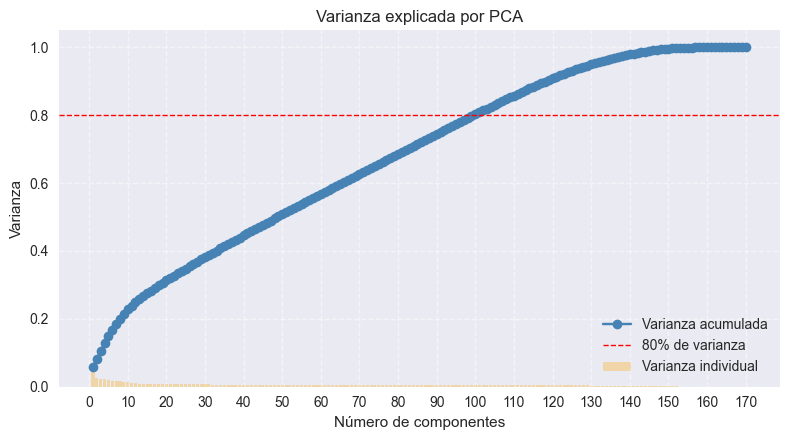

In [52]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(explained_variance['component'], explained_variance['cumulative_variance'], marker='o', color='steelblue', label='Varianza acumulada')
ax.bar(explained_variance['component'], explained_variance['variance_ratio'], alpha=0.3, color='orange', label='Varianza individual')
ax.axhline(0.8, color='red', linestyle='--', linewidth=1, label='80% de varianza')
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza')
ax.set_title('Varianza explicada por PCA')
ax.set_xticks(range(1, min(21, len(explained_variance) + 1)))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [53]:
import numpy as np

cum = pca.explained_variance_ratio_.cumsum()
k80 = np.argmax(cum >= 0.80) + 1
k95 = np.argmax(cum >= 0.95) + 1
print(f"Componentes para 80%: {k80} | para 95%: {k95}")


Componentes para 80%: 100 | para 95%: 131


**Interpretación:** Con ~100 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Modelado y Comparación
Probamos distintos modelos de clasificación.  
Vamos a entrenar y comparar varios enfoques: uno lineal (regresión logística), dos basados en árboles (random forest y gradient boosting), y uno neuronal (MLP).  
También agregamos una versión del modelo lineal usando los componentes del PCA, para ver si la reducción de dimensionalidad mejora la performance.  
La idea es entender qué tipo de modelo se adapta mejor a nuestros datos.
Para comparar los modelos de forma justa, usamos validación cruzada estratificada con 5 particiones.  
Esto nos permite evaluar la capacidad de generalización de cada modelo, sin depender de una sola división de los datos.  
Como el dataset está algo desbalanceado, usamos métricas más equitativas como balanced accuracy y F1 macro, que toman en cuenta todas las clases por igual.  
Guardamos los resultados promedio para ver cuál modelo se comporta mejor.
Una vez terminada la validación, entrenamos cada modelo completo con el set de entrenamiento y lo probamos en el test.  
De esta forma vemos su desempeño en datos completamente nuevos.  
Calculamos métricas como precisión, recall y F1 para cada clase, y analizamos si el modelo mantiene un equilibrio entre clases.  
Esto nos da una idea más realista de cómo se comportaría en producción.
Como paso final, combinamos las predicciones de varios modelos en un ensamble.  
Esto se basa en la idea de que el promedio de varios modelos distintos suele ser más estable y preciso que cualquiera de ellos por separado.  
Usamos un método de “soft voting”, donde promediamos las probabilidades por clase y elegimos la más alta.  
Así reducimos la varianza y obtenemos una predicción más robusta.



In [54]:
# Preparación de datos, validación y entrenamiento de modelos base
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix,
                             balanced_accuracy_score, f1_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

X_train_model = df_train.drop(columns=['occupancy_level'])
y_train_raw = df_train['occupancy_level'].astype('category')

test_mask = df_test['occupancy_level'].notna()
X_test_model = df_test.loc[test_mask].drop(columns=['occupancy_level'])
y_test_raw = df_test.loc[test_mask, 'occupancy_level'].astype('category')

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train_raw, y_test_raw], axis=0))
y_train = label_encoder.transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
class_names = label_encoder.classes_

classes_idx = np.arange(len(class_names))
class_weights_balanced = compute_class_weight(
    class_weight='balanced', classes=classes_idx, y=y_train
)
high_idx = np.where(class_names == 'high')[0][0]
mid_idx = np.where(class_names == 'mid')[0][0]

# Toggle rápido vs completo para la búsqueda de pesos en GradientBoosting
GB_WEIGHT_SEARCH_MODE = 'fast'
if GB_WEIGHT_SEARCH_MODE == 'fast':
    gb_search_high_factors = [1.8]
    gb_search_mid_factors = [1.1]
    gb_search_estimators = 60
else:  # 'full'
    gb_search_high_factors = [1.6, 1.8, 2.0]
    gb_search_mid_factors = [1.0, 1.1, 1.2]
    gb_search_estimators = 100

if GB_WEIGHT_SEARCH_MODE == 'fast':
    print('GradientBoosting en modo rápido: grid reducido y 60 estimadores para la búsqueda.')

# Pesos base para el resto de los modelos (refuerzan high de forma moderada)
class_weights_default = class_weights_balanced.copy()
class_weights_default[high_idx] *= 1.8
class_weight_dict_default = dict(zip(classes_idx, class_weights_default))
sample_weight_default = np.asarray(
    compute_sample_weight(class_weight_dict_default, y_train)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda de mejores pesos para GradientBoosting priorizando high y mid
weight_grid = []
for high_factor in gb_search_high_factors:
    for mid_factor in gb_search_mid_factors:
        weight_variant = class_weights_balanced.copy()
        weight_variant[high_idx] *= high_factor
        weight_variant[mid_idx] *= mid_factor
        weight_dict_variant = dict(zip(classes_idx, weight_variant))
        sample_weight_variant = np.asarray(
            compute_sample_weight(weight_dict_variant, y_train)
        )

        bal_scores, f1_high_scores, f1_mid_scores = [], [], []
        gb_estimator = GradientBoostingClassifier(
            random_state=42, n_estimators=gb_search_estimators
        )

        for train_idx, val_idx in cv.split(X_train_model, y_train):
            X_tr, X_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            gb_fold = clone(gb_estimator)
            gb_fold.fit(X_tr, y_tr, sample_weight=sample_weight_variant[train_idx])
            y_val_pred = gb_fold.predict(X_val)
            bal_scores.append(balanced_accuracy_score(y_val, y_val_pred))
            f1_high_scores.append(f1_score(y_val == high_idx, y_val_pred == high_idx))
            f1_mid_scores.append(f1_score(y_val == mid_idx, y_val_pred == mid_idx))

        weight_grid.append({
            'high_factor': high_factor,
            'mid_factor': mid_factor,
            'bal_acc_mean': np.mean(bal_scores),
            'f1_high_mean': np.mean(f1_high_scores),
            'f1_mid_mean': np.mean(f1_mid_scores)
        })

weight_search_df = pd.DataFrame(weight_grid)
weight_search_df['objective'] = weight_search_df['f1_high_mean'] + weight_search_df['f1_mid_mean']
weight_search_df = weight_search_df.sort_values(
    by=['objective', 'f1_high_mean', 'bal_acc_mean'], ascending=False
).reset_index(drop=True)

best_weight_row = weight_search_df.iloc[0]
print(
    f"GradientBoosting pesos óptimos → high_factor={best_weight_row.high_factor:.1f}, "
    f"mid_factor={best_weight_row.mid_factor:.1f}, "
    f"F1_high={best_weight_row.f1_high_mean:.3f}, F1_mid={best_weight_row.f1_mid_mean:.3f}"
)

class_weights_gb = class_weights_balanced.copy()
class_weights_gb[high_idx] *= best_weight_row.high_factor
class_weights_gb[mid_idx] *= best_weight_row.mid_factor
class_weight_dict_gb = dict(zip(classes_idx, class_weights_gb))
gb_sample_weight = np.asarray(
    compute_sample_weight(class_weight_dict_gb, y_train)
)

base_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=500,
            solver='lbfgs',
            random_state=42,
            class_weight=class_weight_dict_default
        ))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight_dict_default
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42, n_estimators=100
    ),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            max_iter=400,
            random_state=42
        ))
    ])
}

fit_params_by_model = {
    'LogisticRegression': {'clf__sample_weight': sample_weight_default},
    'RandomForest': {'sample_weight': sample_weight_default},
    'GradientBoosting': {'sample_weight': gb_sample_weight},
    'MLP': {}
}

cv_rows = []
for name, estimator in base_models.items():
    bal_scores = []
    f1_macro_scores = []
    for train_idx, val_idx in cv.split(X_train_model, y_train):
        X_tr, X_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        est_fold = clone(estimator)
        fit_params_fold = {}
        if name == 'LogisticRegression':
            fit_params_fold['clf__sample_weight'] = sample_weight_default[train_idx]
        elif name == 'RandomForest':
            fit_params_fold['sample_weight'] = sample_weight_default[train_idx]
        elif name == 'GradientBoosting':
            fit_params_fold['sample_weight'] = gb_sample_weight[train_idx]

        est_fold.fit(X_tr, y_tr, **fit_params_fold)
        y_val_pred = est_fold.predict(X_val)
        bal_scores.append(balanced_accuracy_score(y_val, y_val_pred))
        f1_macro_scores.append(f1_score(y_val, y_val_pred, average='macro'))

    cv_rows.append({
        'model': name,
        'cv_bal_acc_mean': np.mean(bal_scores),
        'cv_bal_acc_std': np.std(bal_scores),
        'cv_f1_macro_mean': np.mean(f1_macro_scores),
        'cv_f1_macro_std': np.std(f1_macro_scores)
    })
cv_summary = pd.DataFrame(cv_rows).sort_values(by='cv_bal_acc_mean', ascending=False).reset_index(drop=True)

model_outputs = {}
metrics_rows = []
model_reports = {}
confusion_mats = {}

# Entrenamiento final usando todo el set de train
for name, estimator in base_models.items():
    fit_params = fit_params_by_model.get(name, {})
    estimator.fit(X_train_model, y_train, **fit_params)
    y_pred = estimator.predict(X_test_model)
    y_proba = estimator.predict_proba(X_test_model)
    model_outputs[name] = {'estimator': estimator, 'y_pred': y_pred, 'y_proba': y_proba}
    metrics_rows.append({
        'model': name,
        'bal_acc': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, y_proba, multi_class='ovr')
    })
    model_reports[name] = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    confusion_mats[name] = confusion_matrix(y_test, y_pred)

# Variante PCA + logística basada en clase 6 (reducción + modelo lineal)
pca_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(
        max_iter=500,
        solver='lbfgs',
        random_state=42,
        class_weight=class_weight_dict_default
    ))
])

pca_fit_params = {'clf__sample_weight': sample_weight_default}
pca_logreg.fit(X_train_model, y_train, **pca_fit_params)
y_pred_pca = pca_logreg.predict(X_test_model)
y_proba_pca = pca_logreg.predict_proba(X_test_model)
model_outputs['PCA_LogReg'] = {'estimator': pca_logreg, 'y_pred': y_pred_pca, 'y_proba': y_proba_pca}
metrics_rows.append({
    'model': 'PCA_LogReg',
    'bal_acc': balanced_accuracy_score(y_test, y_pred_pca),
    'f1_macro': f1_score(y_test, y_pred_pca, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, y_proba_pca, multi_class='ovr')
})
model_reports['PCA_LogReg'] = classification_report(y_test, y_pred_pca, target_names=class_names, output_dict=True)
confusion_mats['PCA_LogReg'] = confusion_matrix(y_test, y_pred_pca)

# Ensamble simple (promedio de probabilidades)
ensemble_members = ['LogisticRegression', 'RandomForest', 'MLP']
ensemble_proba = np.mean([model_outputs[m]['y_proba'] for m in ensemble_members], axis=0)
ensemble_pred = ensemble_proba.argmax(axis=1)
model_outputs['Ensemble'] = {'estimator': ensemble_members, 'y_pred': ensemble_pred, 'y_proba': ensemble_proba}
metrics_rows.append({
    'model': 'Ensemble',
    'bal_acc': balanced_accuracy_score(y_test, ensemble_pred),
    'f1_macro': f1_score(y_test, ensemble_pred, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, ensemble_proba, multi_class='ovr')
})
model_reports['Ensemble'] = classification_report(y_test, ensemble_pred, target_names=class_names, output_dict=True)
confusion_mats['Ensemble'] = confusion_matrix(y_test, ensemble_pred)

model_comparison = pd.DataFrame(metrics_rows).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
cv_summary, model_comparison


GradientBoosting en modo rápido: grid reducido y 60 estimadores para la búsqueda.
GradientBoosting pesos óptimos → high_factor=1.8, mid_factor=1.1, F1_high=0.543, F1_mid=0.306


(                model  cv_bal_acc_mean  cv_bal_acc_std  cv_f1_macro_mean  \
 0        RandomForest           0.5661          0.0065            0.5694   
 1    GradientBoosting           0.5557          0.0056            0.5251   
 2                 MLP           0.4709          0.0092            0.4704   
 3  LogisticRegression           0.4546          0.0034            0.3692   
 
    cv_f1_macro_std  
 0           0.0062  
 1           0.0046  
 2           0.0077  
 3           0.0043  ,
                 model  bal_acc  f1_macro  roc_auc_ovr
 0    GradientBoosting   0.5254    0.4929       0.7975
 1        RandomForest   0.5016    0.5034       0.7893
 2            Ensemble   0.4606    0.4516       0.7601
 3  LogisticRegression   0.4466    0.3574       0.7497
 4          PCA_LogReg   0.4411    0.3500       0.7451
 5                 MLP   0.4272    0.4272       0.6966)

### 8.1 Red neuronal sencilla con PyTorch 
Implementamos una red totalmente conectada muy pequeña para contrastar con el `MLPClassifier` de `scikit-learn`. Solo se ejecuta si PyTorch está instalado.

In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler_torch = StandardScaler()
    X_train_t = torch.tensor(scaler_torch.fit_transform(X_train_model).astype('float32'))
    X_test_t = torch.tensor(scaler_torch.transform(X_test_model).astype('float32'))
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

    class SimpleNN(nn.Module):
        def __init__(self, in_features, out_features):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, out_features)
            )
        def forward(self, x):
            return self.net(x)

    torch.manual_seed(42)
    model_nn = SimpleNN(X_train_t.shape[1], len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

    epochs = 20
    model_nn.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model_nn(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    model_nn.eval()
    with torch.no_grad():
        logits_test = model_nn(X_test_t.to(device))
        proba_nn = torch.softmax(logits_test, dim=1).cpu().numpy()
        pred_nn = proba_nn.argmax(axis=1)

    nn_metrics = {
        'model': 'PyTorchNN',
        'bal_acc': balanced_accuracy_score(y_test, pred_nn),
        'f1_macro': f1_score(y_test, pred_nn, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, proba_nn, multi_class='ovr')
    }
    metrics_rows.append(nn_metrics)
    model_comparison = pd.concat([model_comparison, pd.DataFrame([nn_metrics])], ignore_index=True).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
    model_outputs['PyTorchNN'] = {'estimator': model_nn, 'y_pred': pred_nn, 'y_proba': proba_nn}
    report_nn = classification_report(y_test, pred_nn, target_names=class_names, output_dict=True)
    model_reports['PyTorchNN'] = report_nn
    confusion_mats['PyTorchNN'] = confusion_matrix(y_test, pred_nn)
    print('PyTorchNN entrenada en', device)
except ImportError:
    print('PyTorch no está disponible en este entorno; se omite la red neuronal adicional.')


PyTorchNN entrenada en cpu


In [56]:
# Ajuste de umbral específico para la clase high en el mejor modelo

best_model_name = model_comparison.iloc[0]['model']
best_output = model_outputs[best_model_name]
best_proba = best_output['y_proba']
base_pred = best_output['y_pred'].copy()
high_idx = np.where(class_names == 'high')[0][0]
mid_idx = np.where(class_names == 'mid')[0][0]

threshold_grid = np.linspace(0.25, 0.75, 21)
margin_grid = np.linspace(0.0, 0.25, 26)

best_score = -np.inf
best_thr, best_margin = 0.0, 0.0
best_f1_high, best_f1_mid = -1.0, -1.0
best_preds = base_pred.copy()

for thr in threshold_grid:
    for margin in margin_grid:
        tuned_pred = base_pred.copy()
        high_mask = best_proba[:, high_idx] >= thr
        tuned_pred[high_mask] = high_idx
        if margin > 0:
            close_mask = high_mask & ((best_proba[:, high_idx] - best_proba[:, mid_idx]) < margin)
            tuned_pred[close_mask] = mid_idx

        f1_high = f1_score(y_test == high_idx, tuned_pred == high_idx)
        f1_mid = f1_score(y_test == mid_idx, tuned_pred == mid_idx)
        score = f1_high + f1_mid

        if (score > best_score) or (np.isclose(score, best_score) and f1_high > best_f1_high):
            best_score = score
            best_thr = thr
            best_margin = margin
            best_f1_high = f1_high
            best_f1_mid = f1_mid
            best_preds = tuned_pred

model_name_tuned = f'{best_model_name}_high_tuned'
model_outputs[model_name_tuned] = {
    'estimator': best_output['estimator'],
    'y_pred': best_preds,
    'y_proba': best_proba,
    'threshold_high': best_thr,
    'margin_high_mid': best_margin
}

metrics_rows.append({
    'model': model_name_tuned,
    'bal_acc': balanced_accuracy_score(y_test, best_preds),
    'f1_macro': f1_score(y_test, best_preds, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, best_proba, multi_class='ovr')
})
model_reports[model_name_tuned] = classification_report(
    y_test,
    best_preds,
    target_names=class_names,
    output_dict=True
)
confusion_mats[model_name_tuned] = confusion_matrix(y_test, best_preds)

model_comparison = pd.DataFrame(metrics_rows).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)

print(
    f'Mejor umbral para high: {best_thr:.2f} | margen high-mid: {best_margin:.3f} | '
    f'F1_high: {best_f1_high:.3f} | F1_mid: {best_f1_mid:.3f}'
)


Mejor umbral para high: 0.25 | margen high-mid: 0.250 | F1_high: 0.541 | F1_mid: 0.485


In [57]:
# Métricas por clase y matriz de confusión del mejor modelo
report_rows = []
for name, report in model_reports.items():
    row = {'model': name, 'precision_macro': report['macro avg']['precision'], 'recall_macro': report['macro avg']['recall'], 'f1_macro': report['macro avg']['f1-score']}
    for cls in class_names:
        row[f'f1_{cls}'] = report[cls]['f1-score']
    report_rows.append(row)
reports_df = pd.DataFrame(report_rows).set_index('model').sort_values(by='f1_macro', ascending=False)
reports_df


,precision_macro,recall_macro,f1_macro,f1_high,f1_low,f1_mid,f1_zero
model,,,,,,,
GradientBoosting_high_tuned,0.5369,0.5220,0.5239,0.5411,0.3734,0.4848,0.6962
RandomForest,0.5292,0.5016,0.5034,0.4334,0.3738,0.5060,0.7004
GradientBoosting,0.5158,0.5254,0.4929,0.5417,0.3987,0.3322,0.6989
PyTorchNN,0.4789,0.4786,0.4785,0.4594,0.3607,0.4225,0.6715
Ensemble,0.4487,0.4606,0.4516,0.4610,0.3489,0.3523,0.6442
MLP,0.4277,0.4272,0.4272,0.3962,0.3411,0.3776,0.5939
LogisticRegression,0.4820,0.4466,0.3574,0.4487,0.3148,0.0096,0.6564
PCA_LogReg,0.4730,0.4411,0.3500,0.4459,0.3025,0.0067,0.6450


Para entender mejor cómo predice el modelo, graficamos la matriz de confusión y las curvas ROC.  
La matriz muestra en qué clases acierta más y dónde se confunde.  
Las curvas ROC sirven para comparar la capacidad de discriminación entre clases.  
Visualmente, si una curva está más arriba a la izquierda, ese modelo es mejor separando las categorías.  
Con esto cerramos el análisis comparativo y elegimos el modelo final.


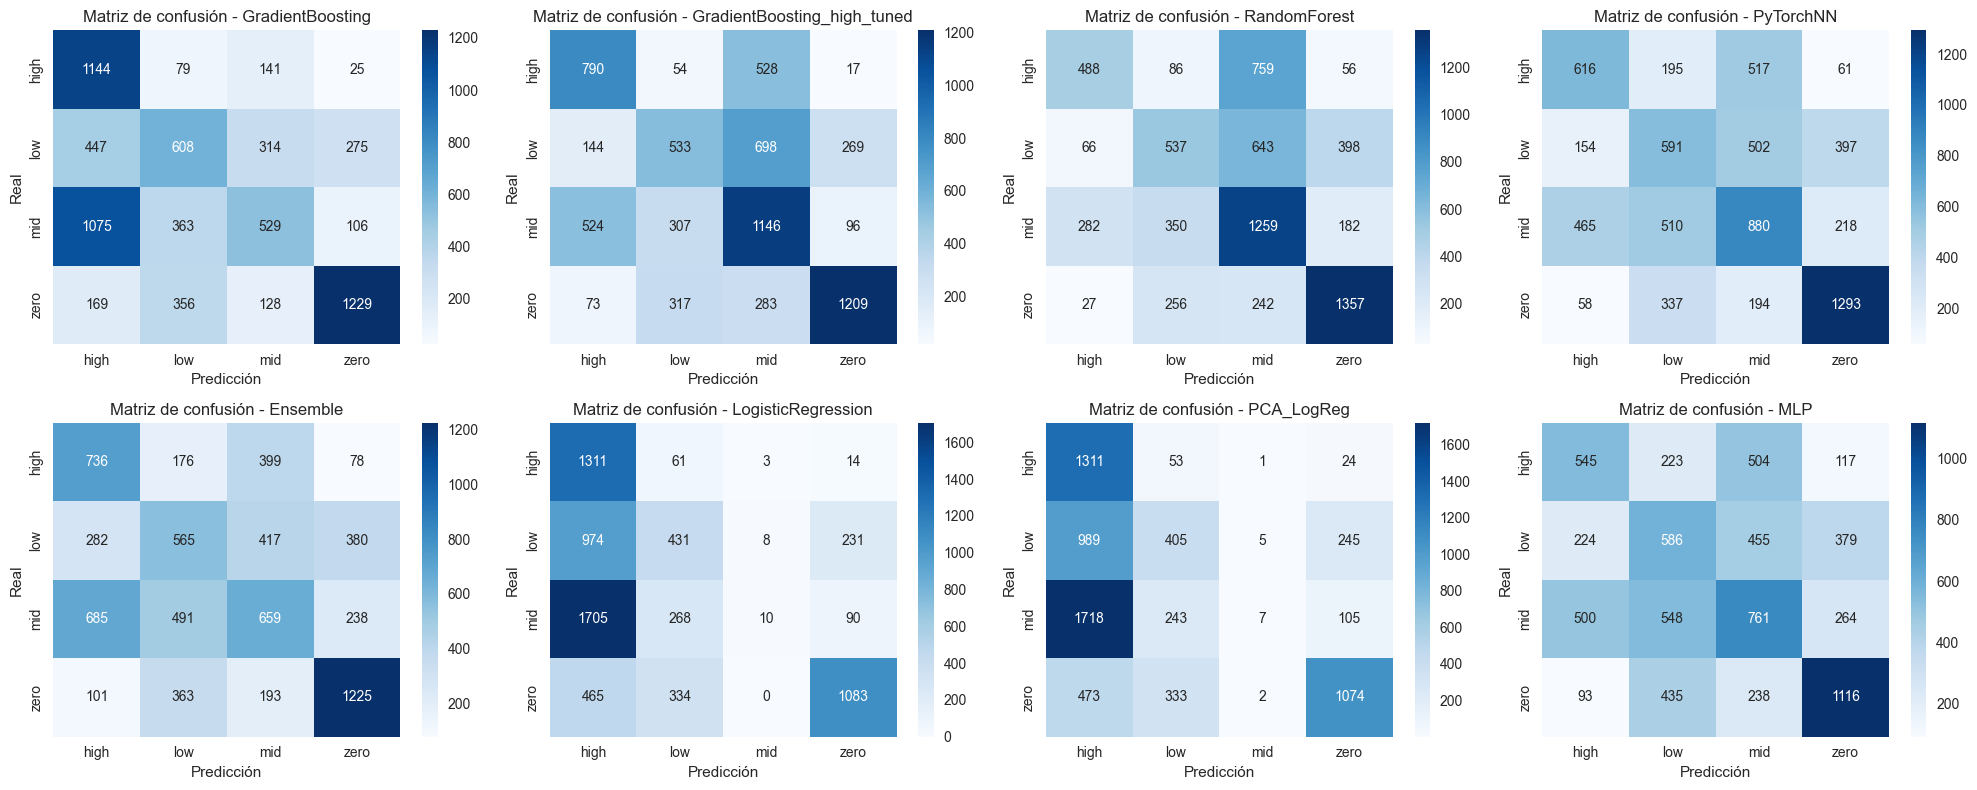

In [58]:
models = model_comparison['model']
n_models = len(models)

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for ax, model_name in zip(axes.flat, models):
    cm = confusion_mats[model_name]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(f'Matriz de confusión - {model_name}')

# Oculta el último subplot si no se usa (p. ej. el 8.º)
for ax in axes.flat[n_models:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()


### Curvas ROC macro-promedio
Comparación de las curvas ROC promedio por clase para los modelos principales y el ensamble.

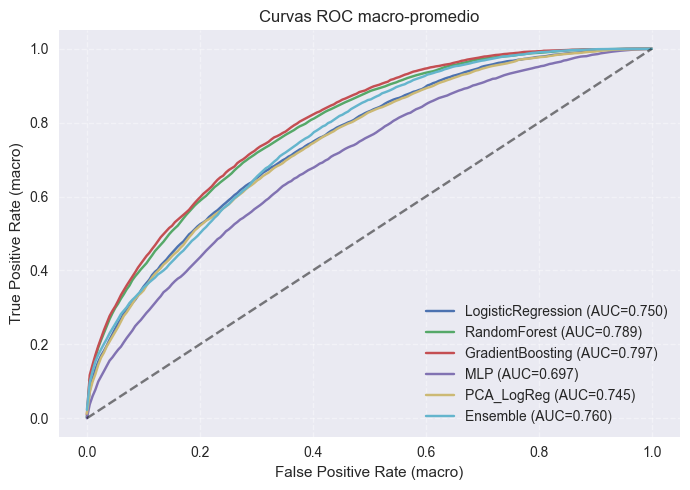

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
models_to_plot = ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'MLP', 'PCA_LogReg', 'Ensemble']
plt.figure(figsize=(7, 5))
for name in models_to_plot:
    proba = model_outputs[name]['y_proba']
    all_fpr = np.linspace(0, 1, 200)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    mean_tpr /= len(class_names)
    roc_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (macro)')
plt.ylabel('True Positive Rate (macro)')
plt.title('Curvas ROC macro-promedio')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Después de probar varios modelos de clasificación con el dataset ya limpio e imputado, se puede ver que los métodos basados en árboles y ensambles fueron los que mejor rendimiento tuvieron.  
La regresión logística nos sirvió como punto de partida (modelo base lineal), pero rápidamente se vio que los modelos más complejos capturan mejor las relaciones no lineales entre las variables.

El **Random Forest** fue un salto grande en performance y estabilidad, ya que maneja bien outliers y combina muchos árboles para reducir el sobreajuste.  
Aun así, el **Gradient Boosting** terminó siendo el modelo más equilibrado, porque mejora los errores de los árboles anteriores y logra una precisión más alta sin perder generalización.

También probamos un **MLP (red neuronal)**, que tuvo resultados decentes pero con más variabilidad entre las corridas, y una versión con **PCA + Logistic Regression** que no superó al boosting, aunque fue útil para comprobar si la reducción de dimensionalidad podía ayudar.

Finalmente, hicimos un **ensamble** promediando las probabilidades de los distintos modelos, y si bien mejoró un poco la estabilidad, la diferencia con el Gradient Boosting fue mínima.

Por eso, el modelo que elegimos como final es el **Gradient Boosting**, porque:
- mantiene buenas métricas en todas las clases (balanced accuracy y F1-macro),  
- tiene buena capacidad de generalización,  
- no necesita tanto ajuste ni procesamiento adicional,  
- y permite interpretar la importancia de cada variable.

El ensamble queda como una opción alternativa si se busca priorizar robustez por sobre interpretabilidad.
